In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import mne
from mne.decoding import ReceptiveField
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale
from scipy import stats
from dataclasses import dataclass, field
from typing import List, Tuple, Dict, Optional
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
from sklearn.preprocessing import scale
from matplotlib import transforms
from matplotlib.patches import Patch
from matplotlib import gridspec
import glob
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import torch.nn.functional as F


# EXTRACT ONSETS

We used this pipline :https://github.com/gwilliams-lab/annotationpipeline to input the wav files and get word and phoneme onsets. We then aligned the surprisal values to each of the words so that we would have time stamped values.

# COMPUTE WHETHER HIGH VS LOW SURPRISAL CHUNKS CHUNKS ARE SIGNIFICANTLY DIFFERENT FROM EACH OTHER

In [3]:
"""
- Reads 4 stories 
- Splits each story into high vs. low surprisal sections 
- Computes GPT-2 token surprisal for each token.
- computes the mean surprisal for low vs. high sections; 
- compares these means across stories with a paired t-test.

"""

#config
BASE_DIR = "/Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/analysis/TRF"
STORY_DIR = "/Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/experiment_files"

STORY_FILES = [
    os.path.join(STORY_DIR, "The fox story.txt"),
    os.path.join(STORY_DIR, "The grasshopper story.txt"),
    os.path.join(STORY_DIR, "The mouse story.txt"),
    os.path.join(STORY_DIR, "The wind story.txt"),
]

# Outputs
OUT_TOKENS_CSV = os.path.join(BASE_DIR, "surprisal_all_stories_tokens.csv")      # optional trace
OUT_STORY_MEANS_CSV = os.path.join(BASE_DIR, "surprisal_per_story_means.csv")    # main result

os.makedirs(BASE_DIR, exist_ok=True)


def get_surprisal_for_text(model, tokenizer, text: str, max_length: int = 1024) -> Tuple[List[str], List[float]]:
    """
    Calculates surprisal for each token in `text` as -log2 P(next token).
    Returns (tokens[1:], surprisals), i.e., each surprisal aligns to the token at the same index.
    Texts longer than model context will be truncated (front).
    """
    # truncate if exceeds max context lenght 
    enc = tokenizer.encode(text)
    if len(enc) > max_length:
        enc = enc[:max_length]
        text = tokenizer.decode(enc)

    inputs = tokenizer(text, return_tensors='pt')
    input_ids = inputs["input_ids"]

    # use cpu
    if torch.cuda.is_available():
        model = model.to("cuda")
        input_ids = input_ids.to("cuda")
    else:
        model = model.to("cpu")

    with torch.no_grad():
        logits = model(input_ids).logits  # [1, T, vocab]

    surprisals = []
    T = input_ids.shape[1]
    for i in range(T - 1):
        next_token_logits = logits[0, i, :]
        next_token_probs = F.softmax(next_token_logits, dim=-1)
        actual_next_id = input_ids[0, i + 1]
        p = next_token_probs[actual_next_id].item()
        surprisal = -math.log2(max(p, 1e-12))  # numerical safety
        surprisals.append(surprisal)

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())
    return tokens[1:], surprisals  # align with surprisals length


def section_labels_for_tokens(num_tokens_per_section: List[int]) -> List[str]:
    """
    Given a list of token counts per section [n0, n1, n2, ...],
    return a label list of same total length with:
        even section -> 'low_surprisal'
        odd section  -> 'high_surprisal'
    """
    labels = []
    for sec_idx, n in enumerate(num_tokens_per_section):
        lab = "low_surprisal" if (sec_idx % 2 == 0) else "high_surprisal"
        labels.extend([lab] * n)
    return labels

# load model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()



all_token_rows = []  # rows: story_name, token, surprisal, label
for story_path in STORY_FILES:
    story_name = os.path.basename(story_path)
    if not os.path.exists(story_path):
        print(f"✗ Missing file: {story_path} (skipping)")
        continue

    print(f"Processing: {story_name}")
    with open(story_path, "r", encoding="utf-8") as f:
        full_text = f.read()

    # Split into sections by blank line; strip and drop empties
    raw_sections = [s.strip() for s in full_text.split("\n\n") if s.strip()]
    if not raw_sections:
        print(f"  ⚠ No non-empty sections found in {story_name}; skipping")
        continue

    # Compute surprisal per section, then concatenate
    story_tokens, story_surprisals, section_lengths = [], [], []
    for sec_text in raw_sections:
        toks, surps = get_surprisal_for_text(model, tokenizer, sec_text, max_length=1024)
        story_tokens.extend(toks)
        story_surprisals.extend(surps)
        section_lengths.append(len(toks))

    # Build labels alternating low/high by section index
    labels = section_labels_for_tokens(section_lengths)

    # Harmonize lengths (token vs surprisal vs label)
    L = min(len(story_tokens), len(story_surprisals), len(labels))
    story_tokens = story_tokens[:L]
    story_surprisals = story_surprisals[:L]
    labels = labels[:L]

    # table
    for tkn, sp, lab in zip(story_tokens, story_surprisals, labels):
        all_token_rows.append({
            "story": story_name,
            "token": tkn,
            "surprisal": float(sp),
            "label": lab
        })


if not all_token_rows:
    raise RuntimeError("No data processed. Check file paths and contents.")

df_all = pd.DataFrame(all_token_rows)
#df_all.to_csv(OUT_TOKENS_CSV, index=False)
#print(f"\n✓ Saved token-level surprisal table (for trace): {OUT_TOKENS_CSV}")

# mean hugh vs low per story
print("per story means:")
per_story = []
for story_name, g in df_all.groupby("story", sort=False):
    low_mean = g[g["label"] == "low_surprisal"]["surprisal"].mean()
    high_mean = g[g["label"] == "high_surprisal"]["surprisal"].mean()
    per_story.append((story_name, low_mean, high_mean))
    print(f"{story_name:>26}: mean Low={low_mean:.4f} | mean High={high_mean:.4f}")

# per-story means table
means_df = pd.DataFrame(per_story, columns=["story", "mean_low", "mean_high"])
means_df["diff_high_minus_low"] = means_df["mean_high"] - means_df["mean_low"]


# Paired t-test across stories (high vs low means)
if len(per_story) >= 2:
    low_means = means_df["mean_low"].to_numpy()
    high_means = means_df["mean_high"].to_numpy()
    t_pair, p_pair = stats.ttest_rel(high_means, low_means)  # paired across stories
    diff = high_means - low_means
    dz = np.mean(diff) / (np.std(diff, ddof=1) + 1e-12)      # Cohen's dz for paired samples

    print("Paired t-test across story means (High vs Low):")
    print(f"  t = {t_pair:.3f}, p = {p_pair:.6f}, Cohen's dz = {dz:.3f}")
    print(f"  Grand means -> Low: {low_means.mean():.4f}, High: {high_means.mean():.4f}")
else:
    print("Not enough stories for a paired t-test of means (need ≥2).")



Processing: The fox story.txt
Processing: The grasshopper story.txt
Processing: The mouse story.txt
Processing: The wind story.txt
per story means:
         The fox story.txt: mean Low=4.4110 | mean High=5.5365
 The grasshopper story.txt: mean Low=5.4242 | mean High=6.0249
       The mouse story.txt: mean Low=4.8875 | mean High=6.0337
        The wind story.txt: mean Low=4.9008 | mean High=6.0063
Paired t-test across story means (High vs Low):
  t = 7.561, p = 0.004798, Cohen's dz = 3.781
  Grand means -> Low: 4.9059, High: 5.9004


# FEATURE EXTRACTION FOR EACH STORY

In [4]:
"""
TRF Feature Extraction
- Reads SUB_XX.xlsx and validates .wav files from SUB_DIR
- Reads slider CSVs from RAW_DIR
- Reads alignment CSVs from BASE_DIR
- Writes all outputs to BASE_DIR
"""


RAW_DIR  = "/Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/data/raw_data"          # slider CSVs
SUB_DIR  = "/Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/experiment_files"       # sub-XX.xlsx and .wav files

# verify that each wav_file referenced in sub-XX.xlsx exists in SUB_DIR
VERIFY_WAV_FILES = True

# story  names to use file detection
STORIES = [
    "fox_story", "fox_sped",
    "mouse_story", "mouse_sped",
    "wind_story", "wind_sped",
    "grasshopper_story", "grasshopper_sped"
]

# slider CSV filename pattern
# slider_p_{pid}_001_{wav_file}.csv
SLIDER_PATTERN = "slider_p_{pid}_001_{wav}.csv"

# columns in the sub-{pid}.xlsx file
SUB_FILE = "sub-{pid:02d}.xlsx"               # columns: 'wav_file', 'slider' (yes/no)
SUB_REQUIRED_COLS = {"wav_file", "slider"}

# columns expected in alignment CSVs (original division of labor)
ALIGN_ONSET_REQUIRED_COLS    = {"Word_Onset_Samples", "Surprisal"}          # in {story}_onset.csv
ALIGN_BOUNDARY_REQUIRED_COLS = {"Surprisal_Boundary"}                       # in {story}_surprisal_boundary.csv


def _ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)

def _p_base(path: str) -> str:
    return os.path.join(BASE_DIR, path)

def _p_raw(path: str) -> str:
    return os.path.join(RAW_DIR, path)

def _p_sub(path: str) -> str:
    return os.path.join(SUB_DIR, path)

def _read_sub_file(pid: int) -> pd.DataFrame:
    """Read SUB_DIR/sub-{pid}.xlsx and filter rows with slider == 'yes' in original order."""
    fp = _p_sub(SUB_FILE.format(pid=pid))
    if not os.path.exists(fp):
        raise FileNotFoundError(f"Missing {os.path.basename(fp)} in SUB_DIR: {SUB_DIR}")

    df = pd.read_excel(fp)
    missing = SUB_REQUIRED_COLS - set(df.columns)
    if missing:
        raise ValueError(f"{os.path.basename(fp)} is missing columns: {missing}")

    # Optional: verify wav files exist in SUB_DIR
    if VERIFY_WAV_FILES:
        missing_wavs = [w for w in df["wav_file"].astype(str) if not os.path.exists(_p_sub(w))]
        if missing_wavs:
            raise FileNotFoundError(
                "The following wav files listed in "
                f"{os.path.basename(fp)} do not exist in SUB_DIR:\n  - " + "\n  - ".join(missing_wavs)
            )

    yes_df = df[df["slider"].astype(str).str.lower().eq("yes")].copy()
    if yes_df.empty:
        raise ValueError(f"{os.path.basename(fp)} has no rows with slider='yes'")
    if len(yes_df) != 4:
        print(f"⚠ sub-{pid:02d}.xlsx: expected 4 stories with slider='yes', found {len(yes_df)}")

    return yes_df.reset_index(drop=True)

def _robust_read_slider_csv(path: str) -> pd.DataFrame:
    """
    Robustly read slider CSVs that sometimes have 1–2 junk header rows.
    We return a DataFrame with exactly ['value', 'time'] (float).
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing slider CSV in RAW_DIR: {os.path.basename(path)}")

    for skip in (0, 1, 2):
        try:
            df = pd.read_csv(path, skiprows=skip)
            cols = [c.strip().lower() for c in df.columns]
            if "value" in cols and "time" in cols:
                df.columns = cols
                out = df[["value", "time"]].copy()
                out["value"] = pd.to_numeric(out["value"], errors="coerce")
                out["time"] = pd.to_numeric(out["time"], errors="coerce")
                out = out.dropna(subset=["value", "time"]).reset_index(drop=True)
                return out
        except Exception:
            pass
    raise ValueError(f"{os.path.basename(path)}: could not find ['value','time'] after trying skiprows=0/1/2")

def _wav_to_story_base(wav_filename: str) -> str:
    """
    Make robust: accept names like:
      - 'fox_story_noise.wav'
      - 'fox_story_noise.wav.csv'
      - bare 'fox_story_noise'
    Return canonical story base without suffixes/extensions, e.g. 'fox_story'.
    """
    base = str(wav_filename).strip()

    # Strip trailing container extension(s)
    if base.endswith(".csv"):
        base = base[:-4]
    if base.endswith(".wav"):
        base = base[:-4]

    # Now remove known recording suffixes
    if base.endswith("_noise"):
        base = base[:-6]

    return base

# --- alignment readers (stick to original logic: onset vs boundary are separate) ---

def _read_onset(story_base: str) -> pd.DataFrame:
    """
    Read {story_base}_onset.csv from BASE_DIR and return Word_Onset_Samples + Surprisal.
    (No requirement for Surprisal_Boundary here — matches original code.)
    """
    fp = _p_base(f"{story_base}_onset.csv")
    if not os.path.exists(fp):
        raise FileNotFoundError(f"Missing {os.path.basename(fp)} (required for surprisal impulses).")
    df = pd.read_csv(fp)
    missing = ALIGN_ONSET_REQUIRED_COLS - set(df.columns)
    if missing:
        raise ValueError(f"{os.path.basename(fp)} missing columns: {missing}")
    df = df.copy()
    df["Word_Onset_Samples"] = pd.to_numeric(df["Word_Onset_Samples"], errors="coerce").round().astype("Int64")
    df["Surprisal"] = pd.to_numeric(df["Surprisal"], errors="coerce")
    df = df.dropna(subset=["Word_Onset_Samples"]).reset_index(drop=True)
    return df

def _read_boundary(story_base: str) -> pd.DataFrame:
    """
    Read {story_base}_surprisal_boundary.csv from BASE_DIR and return Surprisal_Boundary labels.
    If 'Word_Onset_Samples' is present, we’ll use that for placement; otherwise we’ll use row indices
    (which mirrors the original index-based binary-vector construction).
    """
    fp = _p_base(f"{story_base}_surprisal_boundary.csv")
    if not os.path.exists(fp):
        raise FileNotFoundError(f"Missing {os.path.basename(fp)} (required for Low/High boundary vectors).")
    df = pd.read_csv(fp)
    missing = ALIGN_BOUNDARY_REQUIRED_COLS - set(df.columns)
    if missing:
        raise ValueError(f"{os.path.basename(fp)} missing columns: {missing}")
    df = df.copy()
    # Normalize boundary labels
    df["Surprisal_Boundary"] = df["Surprisal_Boundary"].astype(str).str.strip().str.title()
    # Optional onset column (used if present)
    if "Word_Onset_Samples" in df.columns:
        df["Word_Onset_Samples"] = pd.to_numeric(df["Word_Onset_Samples"], errors="coerce").round().astype("Int64")
    return df

def _slider_file_for_story(pid: int, wav_file: str) -> str:
    """
    Return the RAW_DIR path for this participant's slider CSV for wav_file.
    Enforces the SLIDER_PATTERN.
    """
    expected = SLIDER_PATTERN.format(pid=pid, wav=wav_file)
    path = _p_raw(expected)
    if not os.path.exists(path):
        raise FileNotFoundError(f"Expected slider file in RAW_DIR: {expected}")
    return path

# concatanete slider files for each particiant and onset vectora

def build_participant_slider_and_onsets(pid: int) -> Tuple[pd.DataFrame, Dict[str, np.ndarray], List[Tuple[str, int]]]:
    """
    Returns:
      combined_df: concatenated slider (value,time)
      onset_dict:  {'file_onset': vec, 'story_onset': vec, 'sped_onset': vec}
      sections:    list of (story_base, length) in concatenation order
    """
    sub = _read_sub_file(pid)
    wavs = sub["wav_file"].tolist()

    # read and stack slider files (from RAW_DIR)
    combined = []
    sections = []
    for wav in wavs:
        slider_path = _slider_file_for_story(pid, wav)
        df = _robust_read_slider_csv(slider_path)
        combined.append(df)
        sections.append((_wav_to_story_base(wav), len(df)))

    combined_df = pd.concat(combined, ignore_index=True)
    N = len(combined_df)
    file_onset = np.zeros(N, dtype=int)
    story_onset = np.zeros(N, dtype=int)
    sped_onset = np.zeros(N, dtype=int)

    # mark onsets
    cursor = 0
    for story_base, length in sections:
        file_onset[cursor] = 1
        if story_base.endswith("_story"):
            story_onset[cursor] = 1
        if story_base.endswith("_sped"):
            sped_onset[cursor] = 1
        cursor += length

    # save outputs (into BASE_DIR)
    combined_df.to_csv(_p_base(f"p_{pid}_total_combine.csv"), index=False)
    pd.DataFrame({"file_onset": file_onset}).to_csv(_p_base(f"p_{pid}_total_file_onset.csv"), index=False)
    pd.DataFrame({"story_onset": story_onset}).to_csv(_p_base(f"p_{pid}_total_story_onset.csv"), index=False)
    pd.DataFrame({"sped_onset":  sped_onset}).to_csv(_p_base(f"p_{pid}_total_sped_onset.csv"),  index=False)

    return combined_df, {
        "file_onset": file_onset,
        "story_onset": story_onset,
        "sped_onset":  sped_onset
    }, sections


# per story surprisal  low / high vectors

def build_story_level_vectors():
    """
    For each story_base, create three vectors with length = max slider length across ALL participants
    (scanned in RAW_DIR), and save them to BASE_DIR:
      - {story}_surprisal_vector.csv      (float)   <-- from {story}_onset.csv
      - {story}_low_surprisal_vector.csv  (binary)  <-- from {story}_surprisal_boundary.csv
      - {story}_high_surprisal_vector.csv (binary)  <-- from {story}_surprisal_boundary.csv
    """
    # measure max slider length per story across all participants by scanning slider files in RAW_DIR
    max_len_per_story: Dict[str, int] = {s: 0 for s in STORIES}

    for csv_path in glob.glob(_p_raw("slider_p_*_001_*.csv")):
        fname = os.path.basename(csv_path)
        # Expect pattern: slider_p_{pid}_001_{wav}.csv
        try:
            wav = fname.split("_001_", 1)[1]
        except IndexError:
            # Skip any unexpected filenames
            # print(f"Skipping unrecognized slider filename: {fname}")
            continue
        # remove trailing .csv; keep .wav for _wav_to_story_base to handle
        if wav.endswith(".csv"):
            wav = wav[:-4]

        story_base = _wav_to_story_base(wav)
        if story_base not in STORIES:
            # print(f"Skipping '{fname}' -> parsed '{story_base}' not in STORIES")
            continue
        try:
            df = _robust_read_slider_csv(csv_path)
            max_len_per_story[story_base] = max(max_len_per_story[story_base], len(df))
        except Exception:
            pass

    # build vectors from alignments (from BASE_DIR)
    for story_base in STORIES:
        L = max_len_per_story[story_base]
        if L <= 0:
            raise ValueError(
                f"No slider data found for story '{story_base}' in RAW_DIR. "
                f"Make sure slider CSVs exist for this story across participants."
            )

        # Surprisal impulses from *_onset.csv
        onset_df = _read_onset(story_base)
        surprisal_vec = np.zeros(L, dtype=float)
        for _, row in onset_df.iterrows():
            idx = int(row["Word_Onset_Samples"])
            if 0 <= idx < L:
                s = float(row["Surprisal"]) if not math.isnan(row["Surprisal"]) else 0.0
                surprisal_vec[idx] = s

        # Low/High binaries from *_surprisal_boundary.csv
        boundary_df = _read_boundary(story_base)
        low_vec  = np.zeros(L, dtype=int)
        high_vec = np.zeros(L, dtype=int)

        if "Word_Onset_Samples" in boundary_df.columns and boundary_df["Word_Onset_Samples"].notna().any():
            # use onset indices if provided
            for _, row in boundary_df.iterrows():
                idx = row.get("Word_Onset_Samples")
                if pd.isna(idx):
                    continue
                idx = int(idx)
                if 0 <= idx < L:
                    if row["Surprisal_Boundary"] == "Low":
                        low_vec[idx] = 1
                    elif row["Surprisal_Boundary"] == "High":
                        high_vec[idx] = 1
        else:
            # fallback: mirror original index-based approach (use row positions)
            low_idx  = boundary_df.index[boundary_df["Surprisal_Boundary"] == "Low"].tolist()
            high_idx = boundary_df.index[boundary_df["Surprisal_Boundary"] == "High"].tolist()
            for i in low_idx:
                if 0 <= i < L:
                    low_vec[i] = 1
            for i in high_idx:
                if 0 <= i < L:
                    high_vec[i] = 1

        pd.DataFrame({"Surprisal": surprisal_vec}).to_csv(_p_base(f"{story_base}_surprisal_vector.csv"), index=False)
        pd.DataFrame({"Low":       low_vec}).to_csv(_p_base(f"{story_base}_low_surprisal_vector.csv"), index=False)
        pd.DataFrame({"High":      high_vec}).to_csv(_p_base(f"{story_base}_high_surprisal_vector.csv"), index=False)


# concatenate story-level vectors to per-participant length

def _load_story_vector(story_base: str, kind: str) -> pd.Series:
    """
    kind in {'surprisal','low','high'}
    Returns a Series of appropriate length from BASE_DIR.
    """
    name_map = {
        "surprisal": f"{story_base}_surprisal_vector.csv",
        "low":       f"{story_base}_low_surprisal_vector.csv",
        "high":      f"{story_base}_high_surprisal_vector.csv",
    }
    fp = _p_base(name_map[kind])
    if not os.path.exists(fp):
        raise FileNotFoundError(f"Missing {os.path.basename(fp)} in BASE_DIR – did you run build_story_level_vectors()?")

    df = pd.read_csv(fp)
    col = df.columns[0]
    return df[col]

def _adjust_length(vec: pd.Series, target_len: int) -> pd.Series:
    """Zero-pad or truncate to target_len."""
    if len(vec) == target_len:
        return vec.reset_index(drop=True)
    if len(vec) < target_len:
        pad = pd.Series([0] * (target_len - len(vec)))
        return pd.concat([vec, pad], ignore_index=True)
    return vec.iloc[:target_len].reset_index(drop=True)

def build_participant_feature_concats(pid: int, sections: List[Tuple[str, int]]):
    """
    Using the per-participant story order/lengths (sections), create three concatenated vectors:
      - low, high (binary) and surprisal (float)
    Save into BASE_DIR as:
      p_{pid}_total_low_surprisal.csv
      p_{pid}_total_high_surprisal.csv
      p_{pid}_total_surprisal_values.csv
    """
    parts_low, parts_high, parts_s = [], [], []

    for story_base, L in sections:
        low  = _load_story_vector(story_base, "low")
        high = _load_story_vector(story_base, "high")
        sv   = _load_story_vector(story_base, "surprisal")
        parts_low.append(_adjust_length(low,  L))
        parts_high.append(_adjust_length(high, L))
        parts_s.append(_adjust_length(sv,    L))

    low_all  = pd.concat(parts_low,  ignore_index=True)
    high_all = pd.concat(parts_high, ignore_index=True)
    s_all    = pd.concat(parts_s,    ignore_index=True)

    low_all.to_csv(_p_base(f"p_{pid}_total_low_surprisal.csv"),  index=False)
    high_all.to_csv(_p_base(f"p_{pid}_total_high_surprisal.csv"), index=False)
    s_all.to_csv(_p_base(f"p_{pid}_total_surprisal_values.csv"),  index=False)


def main(pids: List[int]):
    print("TRF feature build")
    print(f"  SUB_DIR : {SUB_DIR}   (sub-XX.xlsx + .wav files)")
    print(f"  RAW_DIR : {RAW_DIR}   (slider CSVs)")
    print(f"  BASE_DIR: {BASE_DIR}  (alignment CSVs + outputs)\n")

    _ensure_dir(BASE_DIR)

    # story vectors (based on max slider length across participants in RAW_DIR)
    print("Step 1/3: Building story-level surprisal / low / high vectors ...")
    build_story_level_vectors()
    print("  ✓ Done.\n")

    # participant concatenated sliders + onset vectors
    print("Step 2/3: Building per-participant concatenated sliders & onsets ...")
    sections_per_pid: Dict[int, List[Tuple[str, int]]] = {}
    for pid in pids:
        try:
            _, _, sections = build_participant_slider_and_onsets(pid)
            sections_per_pid[pid] = sections
            print(f"  ✓ p={pid}: concatenated {sum(L for _, L in sections)} rows")
        except Exception as e:
            print(f"  ✗ p={pid}: {e}")
    print("  ✓ Done (with above warnings if any).\n")

    # participant concatenated low/high/surprisal using story vectors
    print("Step 3/3: Building per-participant concatenated low/high/surprisal vectors ...")
    for pid, sections in sections_per_pid.items():
        try:
            build_participant_feature_concats(pid, sections)
            print(f"  ✓ p={pid}: saved low/high/surprisal concatenations")
        except Exception as e:
            print(f"  ✗ p={pid}: {e}")
    print("All done!") #cute

if __name__ == "__main__":
    # Process participants 1..30
    main(list(range(1, 31)))



TRF feature build
  SUB_DIR : /Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/experiment_files   (sub-XX.xlsx + .wav files)
  RAW_DIR : /Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/data/raw_data   (slider CSVs)
  BASE_DIR: /Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/analysis/TRF  (alignment CSVs + outputs)

Step 1/3: Building story-level surprisal / low / high vectors ...
  ✓ Done.

Step 2/3: Building per-participant concatenated sliders & onsets ...
  ✓ p=1: concatenated 108281 rows
  ✓ p=2: concatenated 111442 rows
  ✓ p=3: concatenated 107417 rows
  ✓ p=4: concatenated 112271 rows
  ✓ p=5: concatenated 108250 rows
  ✓ p=6: concatenated 111390 rows
  ✓ p=7: concatenated 108208 rows
  ✓ p=8: concatenated 111418 rows
  ✓ p=9: concatenated 107357 rows
  ✓ p=10: concatenated 112265 rows
  ✓ p=11: concatenated 108224 rows
  ✓ p=12: concatenated 111451 rows
  ✓ p=1

# TRF ANALYSIS 

In [5]:
@dataclass
class Config:
    BASE_PATH: str = "/Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/analysis/TRF"
    SFREQ: float = 249.9
    EXCLUDED: List[int] = field(default_factory=lambda: [2, 13, 17, 25])

    FEATURE_SUFFIXES: Tuple[str, ...] = (
        "_total_low_surprisal_values.csv",
        "_total_high_surprisal_values.csv",
        "_total_surprisal_values.csv",
        "_total_file_onset.csv",
        "_total_sped_onset.csv",
        "_total_story_onset.csv",
    )
    FEATURE_NAMES: Tuple[str, ...] = (
        "low_surprisal",
        "high_surprisal",
        "surprisal",
        "file_onset",
        "sped_onset",
        "story_onset",
    )

    # TRF window (seconds)
    TMIN: float = -0.2
    TMAX: float = 5.0

    # Cross-validation
    N_SPLITS: int = 3

    def participant_ids(self) -> List[int]:
        return [pid for pid in range(1, 31) if pid not in self.EXCLUDED]

CFG = Config()

In [6]:
def _require_file(path: str) -> None:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing required file: {path}")

def load_features(pid: int, cfg: Config = CFG) -> np.ndarray:
    """Load 6 single-column feature CSVs → (6, T_min) trimmed to common length."""
    feats, lengths = [], []
    for suffix in cfg.FEATURE_SUFFIXES:
        p = os.path.join(cfg.BASE_PATH, f"p_{pid}{suffix}")
        _require_file(p)
        s = pd.read_csv(p, header=None).iloc[:, 0]
        s = pd.to_numeric(s, errors="coerce").dropna().astype(float).to_numpy()
        feats.append(s)
        lengths.append(len(s))
    T = min(lengths)
    return np.vstack([f[:T] for f in feats])

def load_slider_as_raw(pid: int, cfg: Config = CFG) -> mne.io.BaseRaw:
    """Load slider CSV (uses only 'value' col) → 1-ch MNE Raw."""
    p = os.path.join(cfg.BASE_PATH, f"p_{pid}_total_combine.csv")
    _require_file(p)
    df = pd.read_csv(p)
    vals = pd.to_numeric(df["value"], errors="coerce").dropna().astype(float).to_numpy()
    info = mne.create_info(ch_names=["slider"], sfreq=cfg.SFREQ, ch_types=["misc"])
    return mne.io.RawArray(vals[None, :], info, verbose="ERROR")


In [7]:
def _make_rf(cfg=CFG):
    return ReceptiveField(
        tmin=cfg.TMIN,
        tmax=cfg.TMAX,
        sfreq=cfg.SFREQ,
        feature_names=list(cfg.FEATURE_NAMES),
        estimator=1.0,      # alpha
        scoring="corrcoef", # we will compute Spearman instead
    )

def _run_kfold(X: np.ndarray, y: np.ndarray, cfg, n_splits: int) -> Tuple[List[float], List[np.ndarray], List[np.ndarray], List[np.ndarray], np.ndarray]:
    """
    Run KFold with n_splits, return:
      spearman_scores, yhat_cat, ytrue_cat, coef_list, times
    """
    kf = KFold(n_splits=n_splits, shuffle=False)
    spearman_scores: List[float] = []
    coef_list: List[np.ndarray] = []
    yhat_cat: List[np.ndarray] = []
    ytrue_cat: List[np.ndarray] = []
    rf_last = None

    for fold, (tr, te) in enumerate(kf.split(X), 1):
        rf = _make_rf(cfg)
        rf.fit(X[tr], y[tr])

        yhat = rf.predict(X[te])
        rho = float(stats.spearmanr(y[te].ravel(), yhat.ravel(), nan_policy="omit").statistic)
        spearman_scores.append(rho)

        yhat_cat.append(yhat.ravel())
        ytrue_cat.append(y[te].ravel())
        coef_list.append(rf.coef_)
        rf_last = rf

        print(f"[n_splits={n_splits}] fold {fold}/{n_splits}: Spearman ρ={rho:.3f}")

    times = rf_last.delays_ / float(rf_last.sfreq)
    return spearman_scores, yhat_cat, ytrue_cat, coef_list, times

# spearman 
def fit_trf_for_participant(pid: int, cfg: Config = CFG) -> Optional[dict]:
    try:
        X = load_features(pid, cfg)         # (6, T)
        raw = load_slider_as_raw(pid, cfg) 
    except FileNotFoundError as e:
        print(f"[p_{pid}] {e} — skipping.")
        return None

    # align lengths
    T = min(X.shape[1], raw.n_times)
    X = X[:, :T].T                # (T, 6)
    y, _ = raw[:]
    y = y.T                       # (T, 1)

    used_splits = cfg.N_SPLITS

    # try 3-fold first, fallback to 2-fold if any NaN 
    try:
        spearman_scores, yhat_cat, ytrue_cat, coef_list, times = _run_kfold(X, y, cfg, cfg.N_SPLITS)
        if any(np.isnan(s) for s in spearman_scores):
            print(f"[p_{pid}] Detected NaN Spearman in {cfg.N_SPLITS}-fold CV → re-running with 2 folds.")
            spearman_scores, yhat_cat, ytrue_cat, coef_list, times = _run_kfold(X, y, cfg, 2)
            used_splits = 2
    except ValueError as e:
        print(f"[p_{pid}] {cfg.N_SPLITS}-fold CV failed ({e}) → re-running with 2 folds.")
        spearman_scores, yhat_cat, ytrue_cat, coef_list, times = _run_kfold(X, y, cfg, 2)
        used_splits = 2

    # aggregate
    coefs = np.stack(coef_list, axis=0)      # (k, 1, 6, n_delays)
    mean_coefs = np.mean(coefs, axis=0)      # (1, 6, n_delays)
    good = [r for r in spearman_scores if not np.isnan(r)]
    mean_spearman = float(np.mean(good)) if good else np.nan

    if used_splits == 2:
        print(f"[p_{pid}] FINAL: ran with 2 folds (mean Spearman ρ={mean_spearman:.3f}).")
    else:
        print(f"[p_{pid}] FINAL: ran with {used_splits} folds (mean Spearman ρ={mean_spearman:.3f}).")

    return dict(
        mean_coefs=mean_coefs,
        mean_scores=mean_spearman,      # set to Spearman 
        times=times,
        y_pred=np.concatenate(yhat_cat),
        y_actual=np.concatenate(ytrue_cat),
        mean_spearman=mean_spearman,
        n_splits_used=used_splits,      
    )

def save_participant_result(pid: int, res: dict, cfg: Config = CFG) -> str:
    """Save in your original format: npz with a 'story' dict."""
    sub_id = f"sub-{pid:02d}"
    out = os.path.join(cfg.BASE_PATH, f"{sub_id}_trf_results_spearman.npz")
    payload = {"story": res}
    np.savez(out, **payload)
    print(f"[p_{pid}] saved → {out}")
    return out

In [8]:
# batch run per participant analysis
def run_and_save_all(cfg: Config = CFG) -> List[int]:
    ok = []
    for pid in cfg.participant_ids():
        res = fit_trf_for_participant(pid, cfg)
        if res is not None:
            save_participant_result(pid, res, cfg)
            ok.append(pid)
    print(f"Completed participants: {ok}")
    return ok


In [9]:
completed = run_and_save_all(CFG)
completed

Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 1/3: Spearman ρ=0.082
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 2/3: Spearman ρ=0.796
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 3/3: Spearman ρ=0.799
[p_1] FINAL: ran with 3 folds (mean Spearman ρ=0.559).
[p_1] saved → /Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/analysis/TRF/sub-01_trf_results_spearman.npz
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 1/3: Spearman ρ=0.243
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 2/3: Spearman ρ=0.143
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 3/3: Spearman ρ=-0.404
[p_3] FINAL: ran with 3 folds (mean Spearman ρ=-0.006).
[p_3] saved → /Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/analysis/TRF/sub-03_trf_results_spearman.npz
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 1/3: Spearman ρ=0.731
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 2/3: Spearman ρ=0.297
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 3/3: Spearman ρ=0.757
[p_4] FINAL: ran with 3 folds (mean Spearman ρ=0.595).
[p_4] saved → /Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/analysis/TRF/sub-04_trf_results_spearman.npz
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 1/3: Spearman ρ=0.820
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 2/3: Spearman ρ=0.796
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 3/3: Spearman ρ=nan
[p_5] Detected NaN Spearman in 3-fold CV → re-running with 2 folds.
Fitting 1 epochs, 6 channels


/var/folders/ns/z1dmbny9559fnq9zm5zly5cr0000gn/T/ipykernel_36909/1709625852.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho = float(stats.spearmanr(y[te].ravel(), yhat.ravel(), nan_policy="omit").statistic)


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=2] fold 1/2: Spearman ρ=0.762
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=2] fold 2/2: Spearman ρ=0.733
[p_5] FINAL: ran with 2 folds (mean Spearman ρ=0.747).
[p_5] saved → /Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/analysis/TRF/sub-05_trf_results_spearman.npz
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 1/3: Spearman ρ=0.413
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 2/3: Spearman ρ=0.181
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 3/3: Spearman ρ=nan
[p_6] Detected NaN Spearman in 3-fold CV → re-running with 2 folds.
Fitting 1 epochs, 6 channels


/var/folders/ns/z1dmbny9559fnq9zm5zly5cr0000gn/T/ipykernel_36909/1709625852.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho = float(stats.spearmanr(y[te].ravel(), yhat.ravel(), nan_policy="omit").statistic)


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=2] fold 1/2: Spearman ρ=-0.646
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=2] fold 2/2: Spearman ρ=0.148
[p_6] FINAL: ran with 2 folds (mean Spearman ρ=-0.249).
[p_6] saved → /Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/analysis/TRF/sub-06_trf_results_spearman.npz
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 1/3: Spearman ρ=0.230
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 2/3: Spearman ρ=0.779
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 3/3: Spearman ρ=0.510
[p_7] FINAL: ran with 3 folds (mean Spearman ρ=0.507).
[p_7] saved → /Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/analysis/TRF/sub-07_trf_results_spearman.npz
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 1/3: Spearman ρ=0.716
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 2/3: Spearman ρ=0.413
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 3/3: Spearman ρ=0.029
[p_8] FINAL: ran with 3 folds (mean Spearman ρ=0.386).
[p_8] saved → /Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/analysis/TRF/sub-08_trf_results_spearman.npz
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 1/3: Spearman ρ=0.137
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 2/3: Spearman ρ=0.257
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 3/3: Spearman ρ=0.101
[p_9] FINAL: ran with 3 folds (mean Spearman ρ=0.165).
[p_9] saved → /Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/analysis/TRF/sub-09_trf_results_spearman.npz
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 1/3: Spearman ρ=0.685
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 2/3: Spearman ρ=0.299
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 3/3: Spearman ρ=0.639
[p_10] FINAL: ran with 3 folds (mean Spearman ρ=0.541).
[p_10] saved → /Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/analysis/TRF/sub-10_trf_results_spearman.npz
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 1/3: Spearman ρ=0.288
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 2/3: Spearman ρ=0.543
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 3/3: Spearman ρ=0.496
[p_11] FINAL: ran with 3 folds (mean Spearman ρ=0.442).
[p_11] saved → /Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/analysis/TRF/sub-11_trf_results_spearman.npz
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 1/3: Spearman ρ=-0.037
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 2/3: Spearman ρ=0.165
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 3/3: Spearman ρ=-0.237
[p_12] FINAL: ran with 3 folds (mean Spearman ρ=-0.036).
[p_12] saved → /Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/analysis/TRF/sub-12_trf_results_spearman.npz
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 1/3: Spearman ρ=0.676
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 2/3: Spearman ρ=0.557
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 3/3: Spearman ρ=-0.071
[p_14] FINAL: ran with 3 folds (mean Spearman ρ=0.387).
[p_14] saved → /Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/analysis/TRF/sub-14_trf_results_spearman.npz
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 1/3: Spearman ρ=0.299
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 2/3: Spearman ρ=0.846
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 3/3: Spearman ρ=0.819
[p_15] FINAL: ran with 3 folds (mean Spearman ρ=0.655).
[p_15] saved → /Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/analysis/TRF/sub-15_trf_results_spearman.npz
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 1/3: Spearman ρ=0.721
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 2/3: Spearman ρ=0.125
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 3/3: Spearman ρ=0.828
[p_16] FINAL: ran with 3 folds (mean Spearman ρ=0.558).
[p_16] saved → /Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/analysis/TRF/sub-16_trf_results_spearman.npz
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 1/3: Spearman ρ=0.030
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 2/3: Spearman ρ=-0.155
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 3/3: Spearman ρ=-0.389
[p_18] FINAL: ran with 3 folds (mean Spearman ρ=-0.171).
[p_18] saved → /Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/analysis/TRF/sub-18_trf_results_spearman.npz
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 1/3: Spearman ρ=-0.214
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 2/3: Spearman ρ=-0.088
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 3/3: Spearman ρ=-0.533
[p_19] FINAL: ran with 3 folds (mean Spearman ρ=-0.278).
[p_19] saved → /Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/analysis/TRF/sub-19_trf_results_spearman.npz
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 1/3: Spearman ρ=0.219
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 2/3: Spearman ρ=0.726
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 3/3: Spearman ρ=0.613
[p_20] FINAL: ran with 3 folds (mean Spearman ρ=0.519).
[p_20] saved → /Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/analysis/TRF/sub-20_trf_results_spearman.npz
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 1/3: Spearman ρ=0.765
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 2/3: Spearman ρ=nan
Fitting 1 epochs, 6 channels


/var/folders/ns/z1dmbny9559fnq9zm5zly5cr0000gn/T/ipykernel_36909/1709625852.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho = float(stats.spearmanr(y[te].ravel(), yhat.ravel(), nan_policy="omit").statistic)


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 3/3: Spearman ρ=0.727
[p_21] Detected NaN Spearman in 3-fold CV → re-running with 2 folds.
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=2] fold 1/2: Spearman ρ=0.699
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=2] fold 2/2: Spearman ρ=0.667
[p_21] FINAL: ran with 2 folds (mean Spearman ρ=0.683).
[p_21] saved → /Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/analysis/TRF/sub-21_trf_results_spearman.npz
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 1/3: Spearman ρ=nan
Fitting 1 epochs, 6 channels


/var/folders/ns/z1dmbny9559fnq9zm5zly5cr0000gn/T/ipykernel_36909/1709625852.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho = float(stats.spearmanr(y[te].ravel(), yhat.ravel(), nan_policy="omit").statistic)


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 2/3: Spearman ρ=nan
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 3/3: Spearman ρ=nan
[p_22] Detected NaN Spearman in 3-fold CV → re-running with 2 folds.
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=2] fold 1/2: Spearman ρ=nan
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=2] fold 2/2: Spearman ρ=nan
[p_22] FINAL: ran with 2 folds (mean Spearman ρ=nan).
[p_22] saved → /Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/analysis/TRF/sub-22_trf_results_spearman.npz
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 1/3: Spearman ρ=0.578
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 2/3: Spearman ρ=0.430
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 3/3: Spearman ρ=nan
[p_23] Detected NaN Spearman in 3-fold CV → re-running with 2 folds.
Fitting 1 epochs, 6 channels


/var/folders/ns/z1dmbny9559fnq9zm5zly5cr0000gn/T/ipykernel_36909/1709625852.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho = float(stats.spearmanr(y[te].ravel(), yhat.ravel(), nan_policy="omit").statistic)


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=2] fold 1/2: Spearman ρ=0.603
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=2] fold 2/2: Spearman ρ=0.235
[p_23] FINAL: ran with 2 folds (mean Spearman ρ=0.419).
[p_23] saved → /Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/analysis/TRF/sub-23_trf_results_spearman.npz
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 1/3: Spearman ρ=-0.172
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 2/3: Spearman ρ=-0.749
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 3/3: Spearman ρ=nan
[p_24] Detected NaN Spearman in 3-fold CV → re-running with 2 folds.
Fitting 1 epochs, 6 channels


/var/folders/ns/z1dmbny9559fnq9zm5zly5cr0000gn/T/ipykernel_36909/1709625852.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho = float(stats.spearmanr(y[te].ravel(), yhat.ravel(), nan_policy="omit").statistic)


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=2] fold 1/2: Spearman ρ=0.184
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=2] fold 2/2: Spearman ρ=-0.015
[p_24] FINAL: ran with 2 folds (mean Spearman ρ=0.085).
[p_24] saved → /Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/analysis/TRF/sub-24_trf_results_spearman.npz
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 1/3: Spearman ρ=0.816
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 2/3: Spearman ρ=0.847
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 3/3: Spearman ρ=0.056
[p_26] FINAL: ran with 3 folds (mean Spearman ρ=0.573).
[p_26] saved → /Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/analysis/TRF/sub-26_trf_results_spearman.npz
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 1/3: Spearman ρ=0.627
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 2/3: Spearman ρ=0.320
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 3/3: Spearman ρ=0.707
[p_27] FINAL: ran with 3 folds (mean Spearman ρ=0.551).
[p_27] saved → /Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/analysis/TRF/sub-27_trf_results_spearman.npz
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 1/3: Spearman ρ=0.717
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 2/3: Spearman ρ=0.231
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 3/3: Spearman ρ=0.761
[p_28] FINAL: ran with 3 folds (mean Spearman ρ=0.570).
[p_28] saved → /Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/analysis/TRF/sub-28_trf_results_spearman.npz
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 1/3: Spearman ρ=0.823
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 2/3: Spearman ρ=-0.136
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 3/3: Spearman ρ=0.803
[p_29] FINAL: ran with 3 folds (mean Spearman ρ=0.497).
[p_29] saved → /Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/analysis/TRF/sub-29_trf_results_spearman.npz
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 1/3: Spearman ρ=0.122
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 2/3: Spearman ρ=0.768
Fitting 1 epochs, 6 channels


  0%|          | Sample : 0/27 [00:00<?,       ?it/s]

[n_splits=3] fold 3/3: Spearman ρ=0.730
[p_30] FINAL: ran with 3 folds (mean Spearman ρ=0.540).
[p_30] saved → /Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/analysis/TRF/sub-30_trf_results_spearman.npz
Completed participants: [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30]


[1,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 14,
 15,
 16,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 26,
 27,
 28,
 29,
 30]

5,6,21,22,23,24 ran on 2 folds

Participants requested: 26 | unique: 26


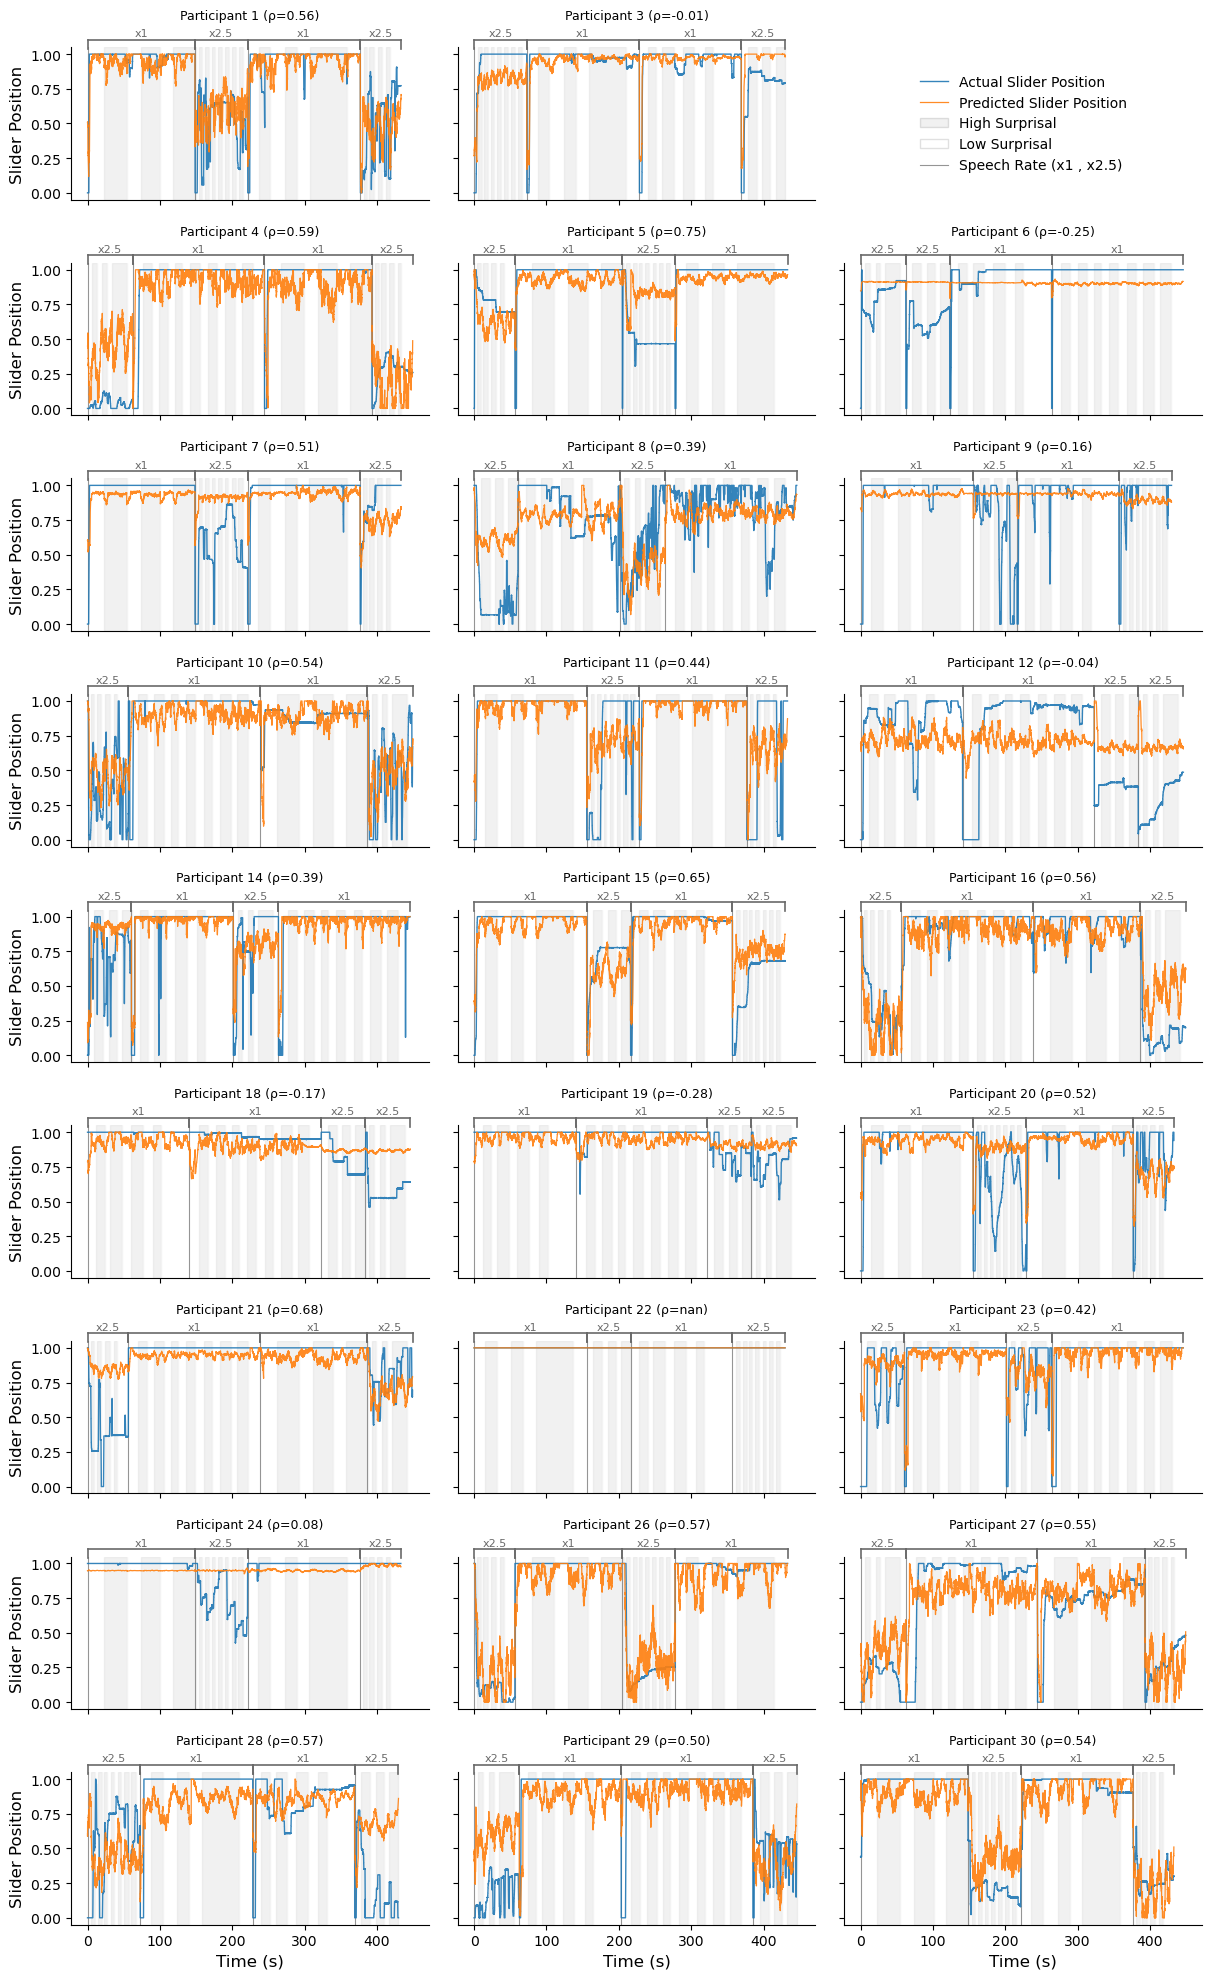

In [10]:
HIGH_COLOR_NAME = "lightgrey"  # high surprisal regions
HIGH_ALPHA      = 0.30
LOW_COLOR_NAME  = "white"      # low surprisal regions
LOW_ALPHA       = 0.30

X1_ONSET_COLOR_NAME  = "dimgray"  # x1 onset lines
X25_ONSET_COLOR_NAME = "dimgray"  # x2.5 onset lines
ONSET_ALPHA, ONSET_LW = 0.7, 0.8

BRACKET_Y, BRACKET_TICK, BRACKET_LW, BRACKET_FSIZE = 1.05, 0.06, 1.2, 8

# 1) Deduplicate and sort participants
pids_raw = list(completed)
pids = sorted(set(int(pid) for pid in pids_raw))
dupe_count = len(pids_raw) - len(pids)
print(f"Participants requested: {len(pids_raw)} | unique: {len(pids)}"
      + (f" | removed duplicates: {dupe_count}" if dupe_count > 0 else ""))

# grid and page config
n_rows, n_cols = 9, 3
legend_idx = 2  # legend  on first row, third column  legend 
per_page_total = n_rows * n_cols
per_page_effective = per_page_total - 1  # one slot is the legend
num_pages = math.ceil(len(pids) / per_page_effective) if pids else 0

# legend config
legend_handles = [
    Line2D([0], [0], lw=1.0, alpha=0.9, color='C0', label='Actual Slider Position'),
    Line2D([0], [0], lw=0.9, alpha=0.9, color='C1', label='Predicted Slider Position'),
    Patch(facecolor=HIGH_COLOR_NAME, edgecolor='0.6', alpha=HIGH_ALPHA, label='High Surprisal'),
    Patch(facecolor=LOW_COLOR_NAME,  edgecolor='0.6', alpha=LOW_ALPHA,  label='Low Surprisal'),
    Line2D([0], [0], lw=ONSET_LW, alpha=ONSET_ALPHA, color=X1_ONSET_COLOR_NAME, label='Speech Rate (x1 , x2.5)'),
]


def _starts_from_csv(csv_path, n_keep):
    """Return indices where the CSV column equals 1.0 (start markers)."""
    if not os.path.exists(csv_path):
        return np.array([], dtype=int)
    s = pd.read_csv(csv_path, header=None).iloc[:, 0]
    s = pd.to_numeric(s, errors="coerce").fillna(0).astype(float).to_numpy()[:n_keep]
    return np.flatnonzero(s == 1.0)

def _shade_surprisal(ax, pid, n, sfreq):
    hi_idx = _starts_from_csv(os.path.join(CFG.BASE_PATH, f"p_{pid}_total_high_surprisal_values.csv"), n)
    lo_idx = _starts_from_csv(os.path.join(CFG.BASE_PATH, f"p_{pid}_total_low_surprisal_values.csv"),  n)
    markers = [(int(i), "high") for i in hi_idx] + [(int(i), "low") for i in lo_idx]
    markers.sort(key=lambda x: (x[0], 0 if x[1] == "high" else 1))

    dedup, last = [], None
    for i, lab in markers:
        if i != last:
            dedup.append((i, lab))
            last = i

    for k, (start_i, lab) in enumerate(dedup):
        end_i = dedup[k + 1][0] if k + 1 < len(dedup) else (n - 1)
        if end_i <= start_i:
            continue
        x0, x1 = start_i / CFG.SFREQ, end_i / CFG.SFREQ
        ax.axvspan(
            x0, x1,
            color=(HIGH_COLOR_NAME if lab == "high" else LOW_COLOR_NAME),
            alpha=(HIGH_ALPHA if lab == "high" else LOW_ALPHA),
            zorder=0
        )

def _onsets_and_brackets(ax, pid, n, sfreq):
    x1_idx  = _starts_from_csv(os.path.join(CFG.BASE_PATH, f"p_{pid}_total_story_onset.csv"), n)
    x25_idx = _starts_from_csv(os.path.join(CFG.BASE_PATH, f"p_{pid}_total_sped_onset.csv"),  n)
    markers = [(int(i), "x1") for i in x1_idx] + [(int(i), "x2.5") for i in x25_idx]
    markers.sort(key=lambda x: (x[0], 0 if x[1] == "x1" else 1))

    # vertical lines
    for i, lab in markers:
        x = i / sfreq
        col = X1_ONSET_COLOR_NAME if lab == "x1" else X25_ONSET_COLOR_NAME
        ax.axvline(x, color=col, alpha=ONSET_ALPHA, lw=ONSET_LW, zorder=2)

    if not markers:
        return

    # brackets
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    for k in range(len(markers) - 1):
        i0, lab = markers[k]
        i1, _   = markers[k + 1]
        if i1 <= i0:
            continue
        x0, x1 = i0 / sfreq, i1 / sfreq
        col = X1_ONSET_COLOR_NAME if lab == "x1" else X25_ONSET_COLOR_NAME
        ax.plot([x0, x1], [BRACKET_Y, BRACKET_Y], transform=trans,
                color=col, lw=BRACKET_LW, clip_on=False, zorder=3)
        ax.plot([x0, x0], [BRACKET_Y, BRACKET_Y - BRACKET_TICK], transform=trans,
                color=col, lw=BRACKET_LW, clip_on=False, zorder=3)
        ax.plot([x1, x1], [BRACKET_Y, BRACKET_Y - BRACKET_TICK], transform=trans,
                color=col, lw=BRACKET_LW, clip_on=False, zorder=3)
        ax.text((x0 + x1) / 2.0, BRACKET_Y + 0.008, lab,
                transform=trans, ha='center', va='bottom',
                fontsize=BRACKET_FSIZE, color=col, clip_on=False, zorder=3)

    # bracket for the last segment 
    ilast, lablast = markers[-1]
    x0, x1 = ilast / sfreq, (n - 1) / sfreq
    if x1 > x0:
        col = X1_ONSET_COLOR_NAME if lablast == "x1" else X25_ONSET_COLOR_NAME
        ax.plot([x0, x1], [BRACKET_Y, BRACKET_Y], transform=trans,
                color=col, lw=BRACKET_LW, clip_on=False, zorder=3)
        ax.plot([x0, x0], [BRACKET_Y, BRACKET_Y - BRACKET_TICK], transform=trans,
                color=col, lw=BRACKET_LW, clip_on=False, zorder=3)
        ax.plot([x1, x1], [BRACKET_Y, BRACKET_Y - BRACKET_TICK], transform=trans,
                color=col, lw=BRACKET_LW, clip_on=False, zorder=3)
        ax.text((x0 + x1) / 2.0, BRACKET_Y + 0.008, lablast,
                transform=trans, ha='center', va='bottom',
                fontsize=BRACKET_FSIZE, color=col, clip_on=False, zorder=3)

# pages
for page in range(num_pages):
    start = page * per_page_effective
    end   = min(start + per_page_effective, len(pids))
    batch = pids[start:end]

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(n_cols * 4.0, n_rows * 2.2),
        sharex=True, sharey=True,
        layout="constrained"
    )
    try:
        
        fig.set_constrained_layout_pads(w_pad=0.04, h_pad=0.10, hspace=0.06, wspace=0.06)
    except Exception:
        pass

    axes = axes.ravel()

    # legend 
    axes[legend_idx].axis("off")
    axes[legend_idx].legend(
        handles=legend_handles,
        loc="center",
        frameon=False,
        fontsize=10,
        title=""
    )

    plot_axes = [ax for i, ax in enumerate(axes) if i != legend_idx]

    # plot participants
    for ax, pid in zip(plot_axes, batch):
        sub_id  = f"sub-{pid:02d}"
        npz_path = os.path.join(CFG.BASE_PATH, f"{sub_id}_trf_results_spearman.npz")
        if not os.path.exists(npz_path):
            ax.text(0.5, 0.5, f"Participant {pid}\nmissing", ha="center", va="center", transform=ax.transAxes)
            ax.set_axis_off()
            continue

        story = np.load(npz_path, allow_pickle=True)["story"].item()
        y_pred = story["y_pred"]
        y_true = story["y_actual"]
        rho    = float(story.get("mean_spearman", np.nan))
        n      = len(y_pred)

        t = np.arange(n) / CFG.SFREQ  # seconds

        # surprisal shading (high/low)
        _shade_surprisal(ax, pid, n, CFG.SFREQ)

        # peech-rate onsets and brackets
        _onsets_and_brackets(ax, pid, n, CFG.SFREQ)

        # normalize slider respinses to be between 0-1
        y_true_01 = y_true.astype(float) / 255.0

        mask = np.isfinite(y_pred) & np.isfinite(y_true_01)
        if mask.sum() >= 2 and (np.nanstd(y_pred[mask]) > 0):
            a, b = np.polyfit(y_pred[mask], y_true_01[mask], 1)
        else:
            a, b = 0.0, float(np.nanmean(y_true_01))
        y_pred_01 = np.clip(a * y_pred + b, 0.0, 1.0)
 

        # plot slider 
        ax.plot(t, y_true_01, lw=1.0, alpha=0.9, label="Actual Slider Position", zorder=4, color='C0')
        ax.plot(t, y_pred_01, lw=0.9, alpha=0.9, label="Predicted Slider Position",      zorder=4, color='C1')

        ax.set_ylim(-0.05, 1.05)
        ax.set_title(f"Participant {pid} (ρ={rho:.2f})", fontsize=9, y=1.03, pad=17)
        ax.grid(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # labels
    for idx, ax in enumerate(axes):
        if idx == legend_idx or not ax.get_visible():
            continue
        r, c = divmod(idx, n_cols)
        if r >= n_rows - 1:
            ax.set_xlabel("Time (s)", fontsize=12)
        if c == 0:
            ax.set_ylabel("Slider Position", fontsize=12)

    # hide unused axes on the last page (except legend)
    used_axes = len(batch)
    for j in range(used_axes + 1, per_page_total):
        if j == legend_idx:
            continue
        axes[j].set_visible(False)

    plt.show()

/var/folders/ns/z1dmbny9559fnq9zm5zly5cr0000gn/T/ipykernel_36909/2643023690.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


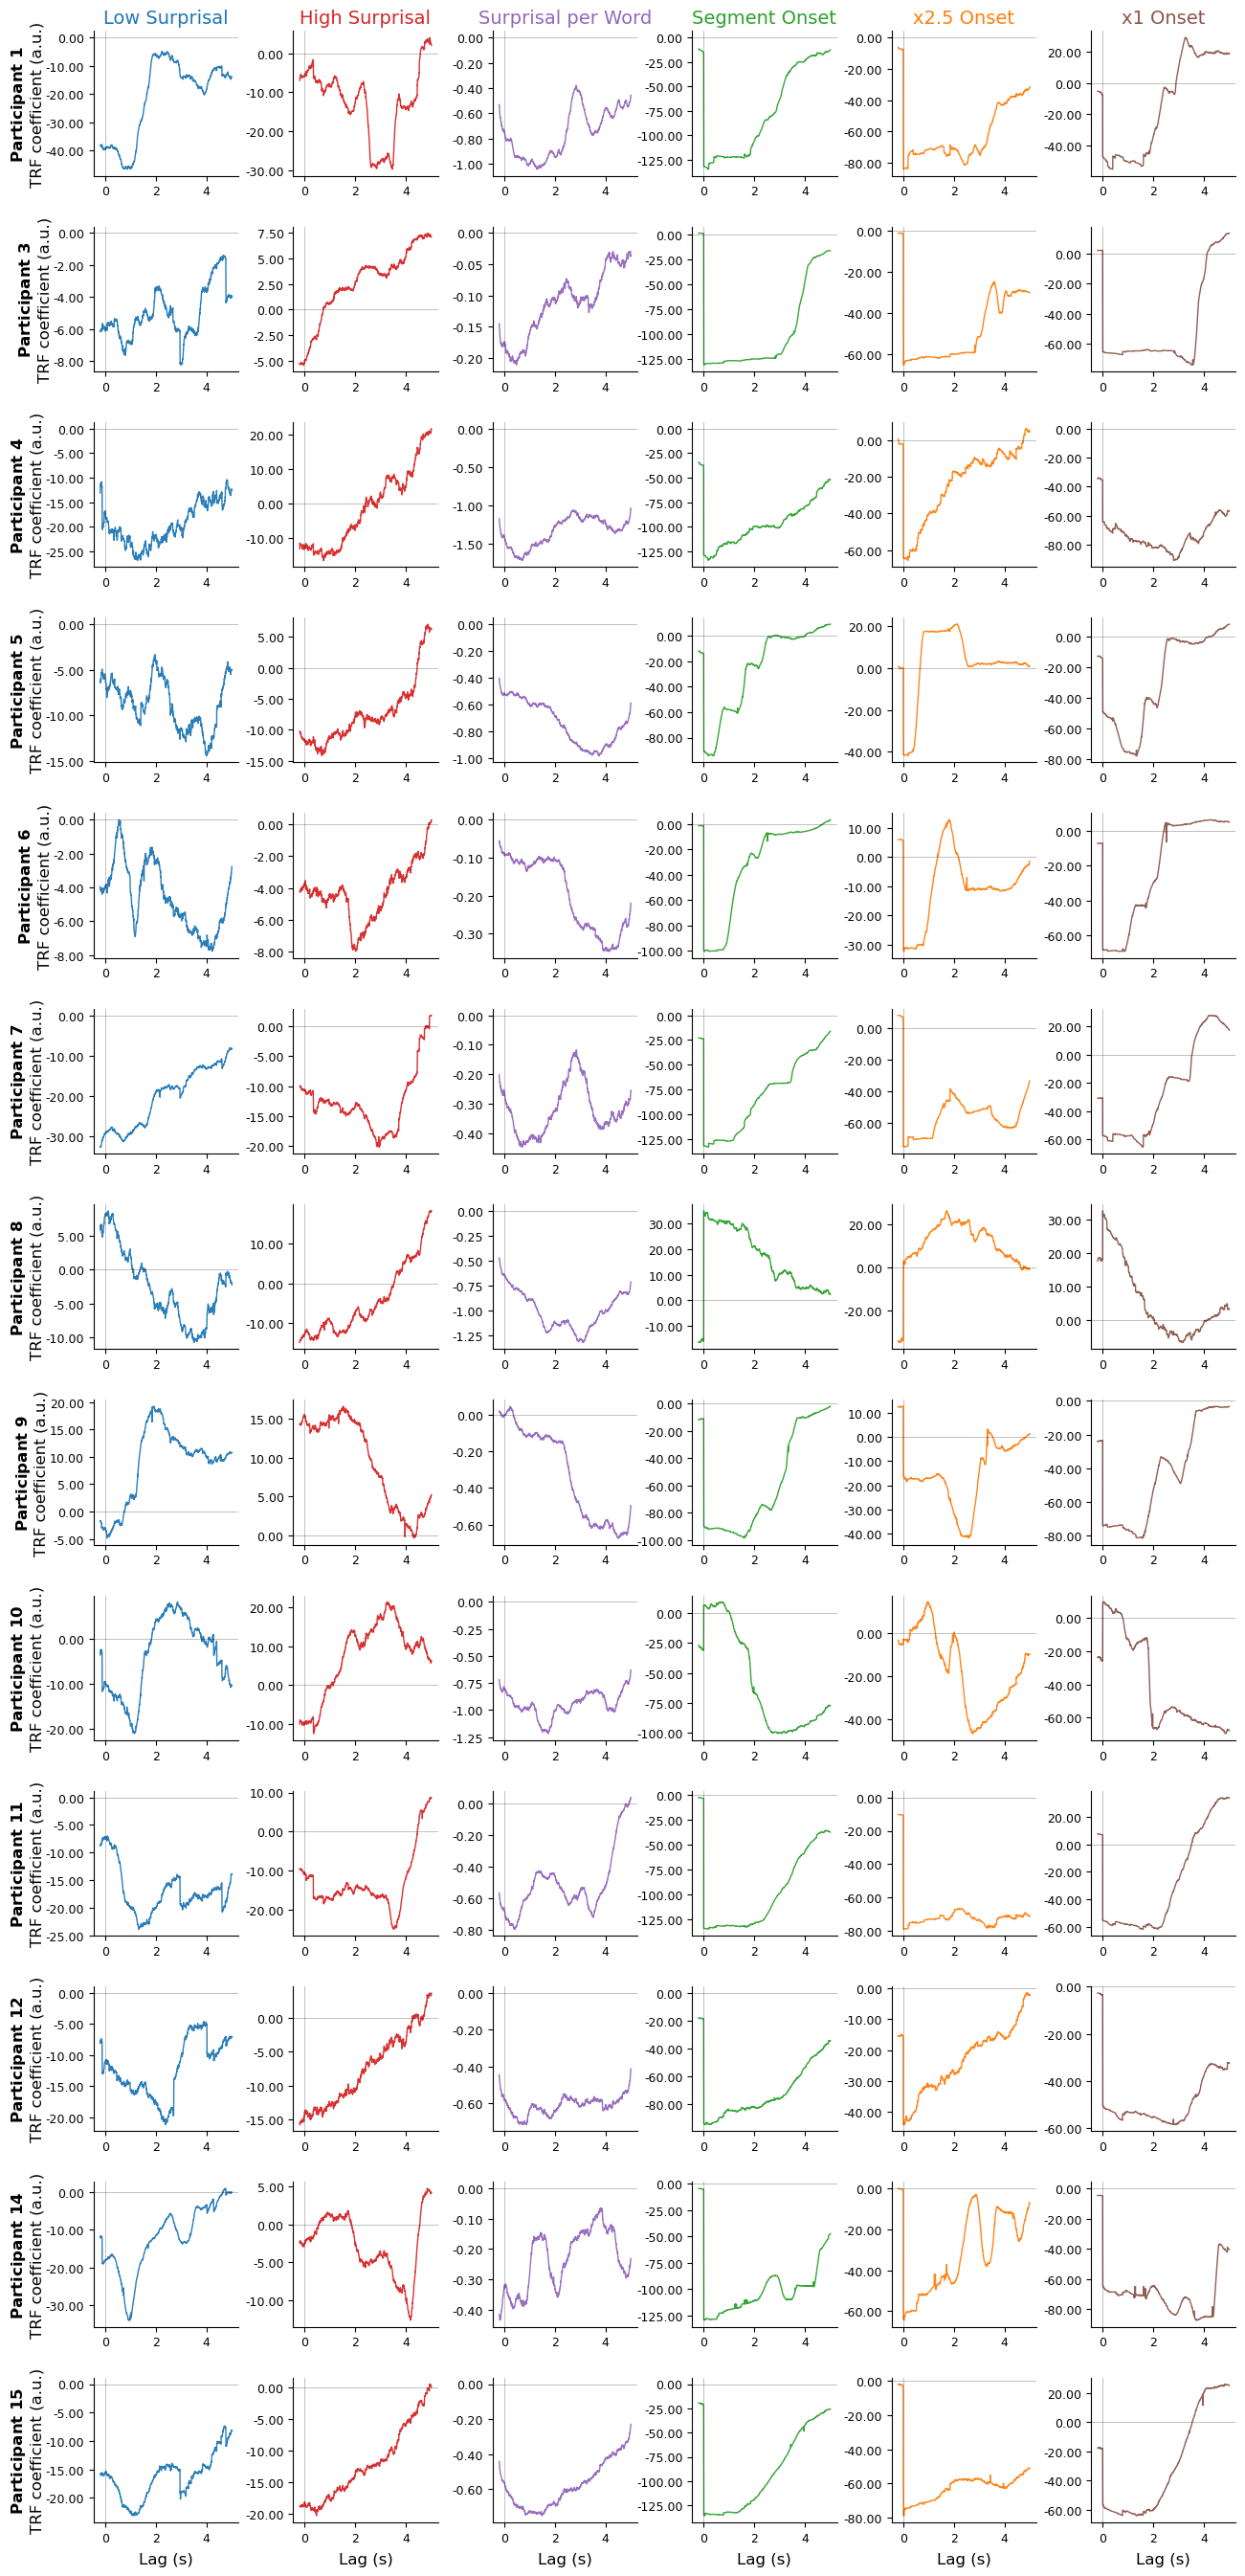

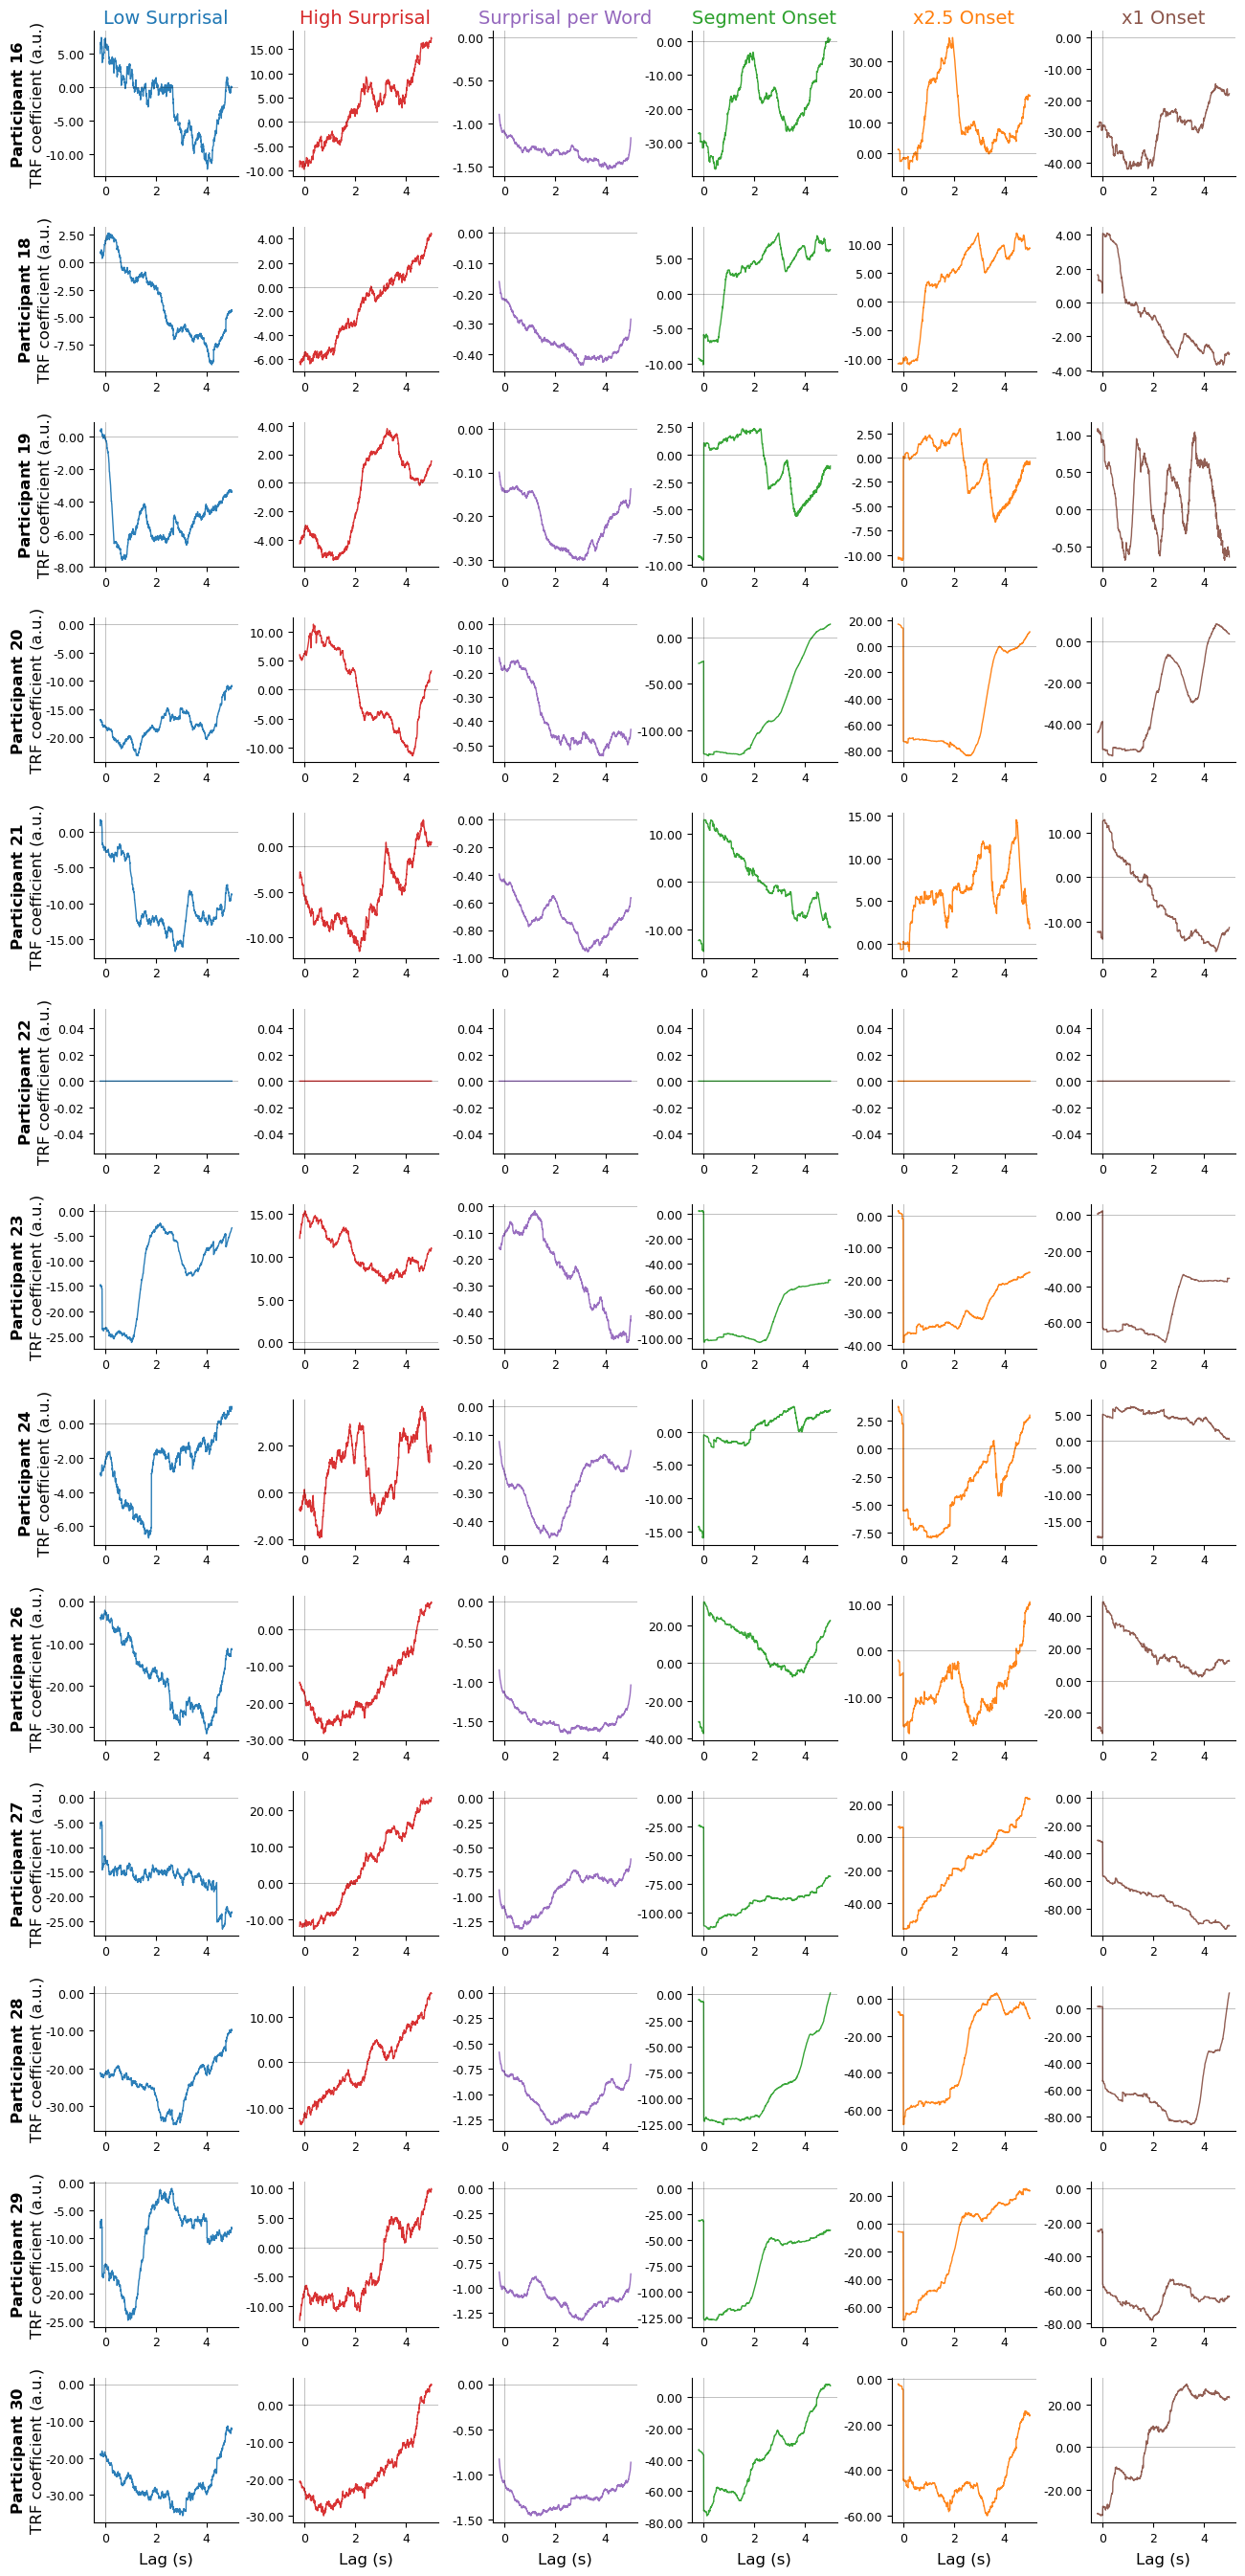

In [18]:
# Plot TRF features

def _yfmt(val, pos):
    return f"{val:.2f}"

# paths
save_dir = "/Users/irmakergin/Desktop/measuring_naturalistic_speech_comprehension_2024/experiment_3/figures"

# Plot TRF coefficients per participant
pids = sorted(set(int(pid) for pid in completed))
valid = [pid for pid in pids
         if os.path.exists(os.path.join(CFG.BASE_PATH, f"sub-{pid:02d}_trf_results_spearman.npz"))]
if not valid:
    raise RuntimeError("No valid participants found.")

# feature labels & colors 
feature_labels = [
    "Low Surprisal",
    "High Surprisal",
    "Surprisal per Word",
    "Segment Onset",
    "x2.5 Onset",
    "x1 Onset",
]
feature_colors = [
    "#1f77b4",
    "#d62728",
    "#9467bd",
    "#2ca02c",
    "#ff7f0e",
    "#8c564b",
]

n_feat = len(feature_labels)
side   = 2.6  # panel size

# split participants into two halves
n_part = len(valid)
mid    = math.ceil(n_part / 2)
parts1 = valid[:mid]      # first half
parts2 = valid[mid:]      # second half

def plot_half(part_list, savepath=None):
    n_rows = len(part_list)
    fig = plt.figure(figsize=(n_feat * side, n_rows * side))
    gs  = gridspec.GridSpec(n_rows, n_feat, wspace=0.25, hspace=0.35, figure=fig)

    for r, pid in enumerate(part_list):
        d = np.load(os.path.join(CFG.BASE_PATH, f"sub-{pid:02d}_trf_results_spearman.npz"),
                    allow_pickle=True)["story"].item()
        coefs = d["mean_coefs"].squeeze(0)
        times = d["times"]

        for c in range(n_feat):
            ax = fig.add_subplot(gs[r, c])
            ax.set_box_aspect(1)

            ax.plot(times, coefs[c], lw=1.0, alpha=0.95, color=feature_colors[c])
            ax.axhline(0, color="k", lw=0.7, alpha=0.25)
            ax.axvline(0, color="k", lw=0.7, alpha=0.25)

            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.yaxis.set_major_formatter(FuncFormatter(_yfmt))
            ax.tick_params(labelsize=9)

            # titles on first participant row
            if r == 0:
                ax.set_title(feature_labels[c], fontsize=14, color=feature_colors[c], pad=6)

            # y-label on first column: bold only "Participant {pid}"
            if c == 0:
                ax.set_ylabel(
                    rf"$\bf{{Participant\ {pid}}}$" + "\nTRF coefficient (a.u.)",
                    fontsize=12,
                    rotation=90,
                    ha="center",
                    va="center",
                    labelpad=14,
                )

            # x-label on bottom row
            if r == n_rows - 1:
                ax.set_xlabel("Lag (s)", fontsize=12, labelpad=6)

    plt.tight_layout()

    if savepath is not None:
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        fig.savefig(savepath, dpi=150, bbox_inches="tight")

    plt.show()

# figure 1: first half
plot_half(
    parts1,
    savepath=os.path.join(
        save_dir,
        "trf_features_all_participants_1.png"
    ),
)

# figure 2: second half
if parts2:
    plot_half(
        parts2,
        savepath=os.path.join(
            save_dir,
            "trf_features_all_participants_2.png"
        ),
    )


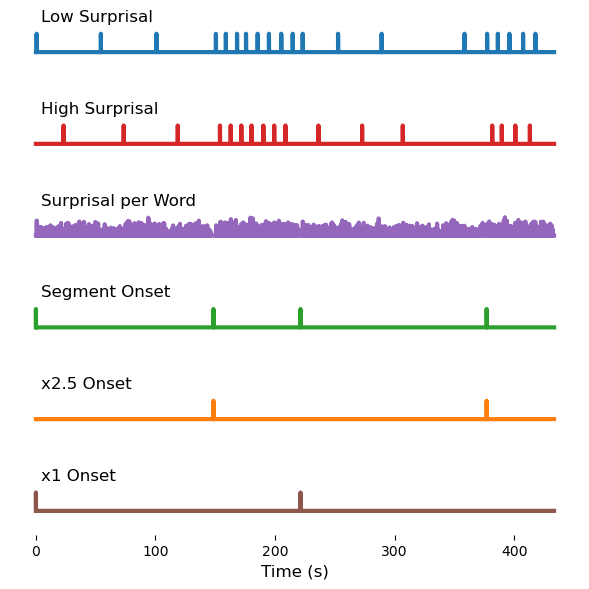

In [ ]:
# Plot feature pulses 

pulses_pids = [valid[0]]

# order 
_feature_files = [
    "_total_low_surprisal_values.csv",   # Low Surprisal
    "_total_high_surprisal_values.csv",  # High Surprisal
    "_total_surprisal_values.csv",       # Surprisal per Word
    "_total_file_onset.csv",             # Segment Onset (x1 & x2.5)
    "_total_sped_onset.csv",             # x2.5 Onset
    "_total_story_onset.csv",            # x1 Onset
]
assert len(_feature_files) == len(feature_labels) == len(feature_colors)

for pid in pulses_pids:

    feats, lengths = [], []
    for suf in _feature_files:
        fpath = os.path.join(CFG.BASE_PATH, f"p_{pid}{suf}")
        if not os.path.exists(fpath):
            raise FileNotFoundError(f"Missing {fpath}")
        s = pd.read_csv(fpath, header=None).iloc[:, 0]
        s = pd.to_numeric(s, errors="coerce").fillna(0).astype(float).to_numpy()
        feats.append(s); lengths.append(len(s))

    T = min(lengths)
    feats = [s[:T] for s in feats]
    F = np.vstack(feats)                 # (6, T)
    t = np.arange(T) / float(CFG.SFREQ)  # seconds

    F_norm = np.empty_like(F, dtype=float)
    for i in range(F.shape[0]):
        fmin, fmax = F[i].min(), F[i].max()
        F_norm[i] = (F[i] - fmin) / (fmax - fmin) if fmax > fmin else np.zeros_like(F[i])

  
    offset = 5.0           # vertical spacing between rows
    TITLE_X_PAD = 0.01     # (in seconds) left padding from plot start for titles
    TITLE_Y_PAD = 0.5     # fraction of a row height above the row (0 = top, >0 = above)
    TITLE_FS    = 12

    fig, ax = plt.subplots(figsize=(6, 6))
    fig.subplots_adjust(left=0.12, right=0.98, top=0.96, bottom=0.12)

    nfeat = F_norm.shape[0]

    for row, i in enumerate(range(nfeat - 1, -1, -1)):  # top-bottom
        y = F_norm[i] + row * offset
        ax.plot(t, y, linewidth=3, color=feature_colors[i], zorder=2)

        # row titles
        x_text = t[0] + TITLE_X_PAD * max(t[-1] - t[0], 1.0)
        y_text = row * offset + 1.0 + TITLE_Y_PAD
        ax.text(x_text, y_text, feature_labels[i],
                color="black", fontsize=TITLE_FS,
                ha="left", va="bottom", clip_on=False, zorder=3)

    ax.set_xlabel("Time (s)", fontsize=12)
    if t[-1] > 0:
        ax.set_xticks(np.arange(0, t[-1] + 1, 100.0))
    ax.grid(False)
    ax.set_frame_on(False)
    ax.set_yticks([])


    plt.tight_layout()
    plt.show()

    # save
    #save_path = os.path.join(os.path.expanduser("~"), "Desktop", "experiment_3")
    #os.makedirs(save_path, exist_ok=True)
    #fig.savefig(os.path.join(save_path, "feature_pulse.svg"),
                #format="svg", bbox_inches="tight")
    #plt.close(fig)



# Group Level Anlaysis

Included participants (n=25): [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21, 23, 24, 26, 27, 28, 29, 30]
Mean ρ = 0.37
t(24) = 6.08,  p = 0.0000028
95% CI  = [0.25, 0.50]


/var/folders/ns/z1dmbny9559fnq9zm5zly5cr0000gn/T/ipykernel_31508/1000063442.py:71: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([spearmans], labels=[""], widths=0.6, patch_artist=True,


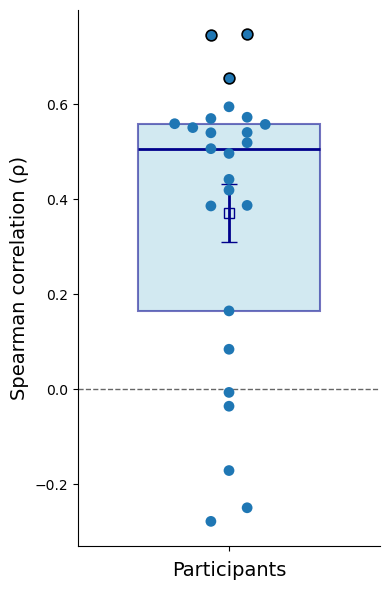

In [ ]:


BASE_PATH = CFG.BASE_PATH            
EXCLUDED  = set(CFG.EXCLUDED)        

spearmans, pids = [], []
for name in sorted(os.listdir(BASE_PATH)):
    if not (name.startswith("sub-") and name.endswith("_trf_results_spearman.npz")):
        continue
    pid = int(name[4:6])
    if pid in EXCLUDED:
        continue  # skip excluded participants

    try:
        d = np.load(os.path.join(BASE_PATH, name), allow_pickle=True)["story"].item()
        r = float(d.get("mean_spearman", np.nan))
    except Exception:
        r = np.nan

    if not np.isnan(r):
        spearmans.append(r)
        pids.append(pid)

spearmans = np.asarray(spearmans, dtype=float)
n = len(spearmans)
if n == 0:
    raise RuntimeError("No valid participants with non-NaN mean_spearman found after exclusions.")

t_stat, p_val = stats.ttest_1samp(spearmans, 0.0, nan_policy="omit")
mean_r = float(np.mean(spearmans))
sd_r   = float(np.std(spearmans, ddof=1)) if n > 1 else 0.0
se_r   = sd_r / np.sqrt(n) if n > 0 else np.nan
if n > 1:
    tcrit = stats.t.ppf(0.975, df=n - 1)
    ci_lo, ci_hi = mean_r - tcrit * se_r, mean_r + tcrit * se_r
else:
    ci_lo, ci_hi = np.nan, np.nan

print(f"Included participants (n={n}): {sorted(pids)}")
print(f"Mean ρ = {mean_r:.2f}")
print(f"t({n-1}) = {t_stat:.2f},  p = {p_val:.7f}")
print(f"95% CI  = [{ci_lo:.2f}, {ci_hi:.2f}]")

# jittering data points
def beeswarm_x(y, x_center=1.0, step=0.06, bin_width=0.03, max_cols=20):
    """
    Beeswarm-like jitter (no seaborn). Bins by y; within each bin,
    offsets start at ±1*step so nothing sits at the center.
    """
    y = np.asarray(y)
    order = np.argsort(y)
    x = np.full_like(y, fill_value=x_center, dtype=float)

    bins = np.floor((y - y.min()) / bin_width).astype(int)
    for b in np.unique(bins):
        idx = order[bins[order] == b]
        m = len(idx)
        if m <= 1:
            continue
        offsets = (np.arange(m) // 2) + 1        
        signs   = np.where(np.arange(m) % 2 == 0, -1.0, +1.0)  
        if offsets.max() > max_cols:
            offsets = np.clip(offsets, 1, max_cols)
        x[idx] = x_center + signs * offsets * step
    return x

fig, ax = plt.subplots(figsize=(4, 6))  

bp = ax.boxplot([spearmans], labels=[""], widths=0.6, patch_artist=True,
                showfliers=False, medianprops=dict(color="darkblue", linewidth=2))
box = bp["boxes"][0]
box.set_facecolor("lightblue")   # shaded box
box.set_alpha(0.55)             
box.set_edgecolor("darkblue")
box.set_linewidth(1.5)
for w in bp.get("whiskers", []): w.set_alpha(0.0)   
for c in bp.get("caps", []):      c.set_alpha(0.0)  

# jitter 
x = beeswarm_x(spearmans, x_center=1.0, step=0.06, bin_width=0.03)

# highlight specific participants
highlight_pids = {5, 21, 15}
mask_hi = np.array([pid in highlight_pids for pid in pids])

# plot dots above the box
ax.scatter(x[~mask_hi], spearmans[~mask_hi], s=60, alpha=1,
           color="tab:blue", edgecolor="none", zorder=4)
ax.scatter(x[mask_hi], spearmans[mask_hi], s=60, alpha=1,
           color="tab:blue", edgecolor="black", linewidth=1.2, zorder=5)

# mean ± SEM as a square hollow marker 

ax.errorbar(1.0, mean_r, yerr=se_r, fmt='s', ms=7, lw=2,
            mfc='none', mec='darkblue', ecolor='darkblue', capsize=6, zorder=3)

# reference line at 0
ax.axhline(0, color="k", lw=1.0, linestyle="--", alpha=0.6)

ax.set_xlabel("Participants", fontsize=14)
ax.set_ylabel("Spearman correlation (ρ)", fontsize=14)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(False)

plt.tight_layout()
plt.show()

#ave_path = os.path.join(os.path.expanduser("~"), "Desktop", "experiment_3")
#os.makedirs(save_path, exist_ok=True)
#fig.savefig(os.path.join(save_path, "participant_box.svg"), format="svg", bbox_inches="tight")



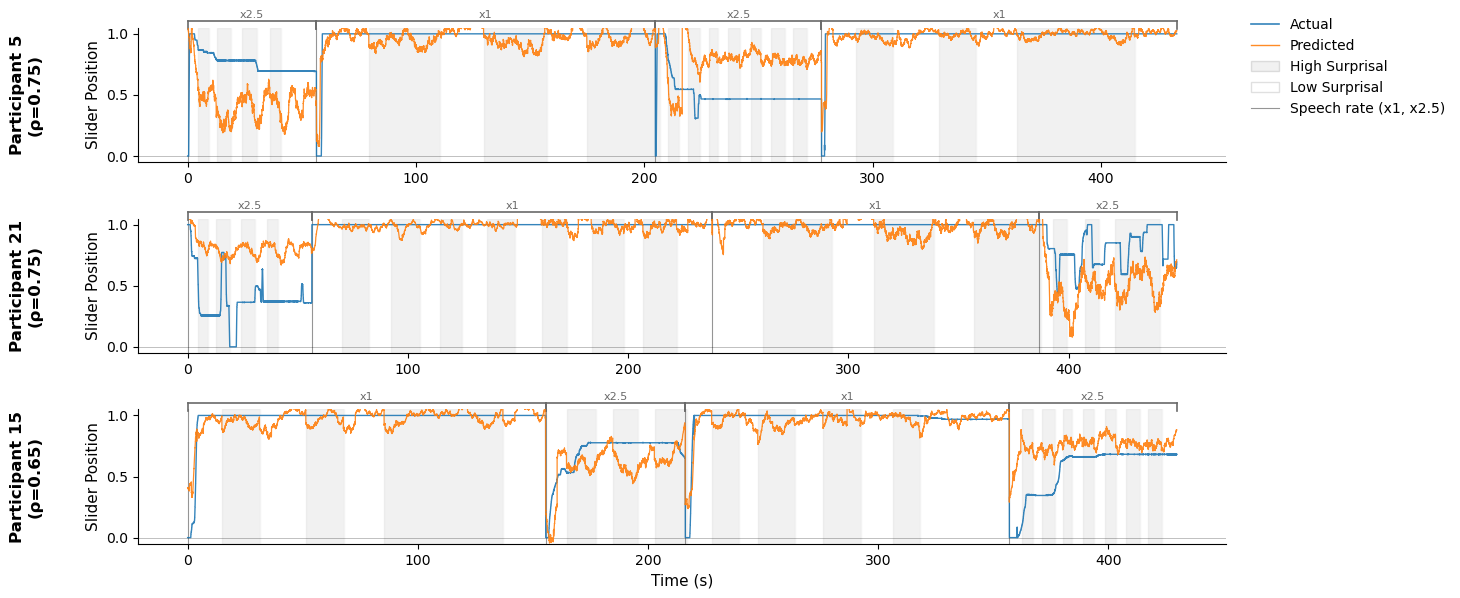

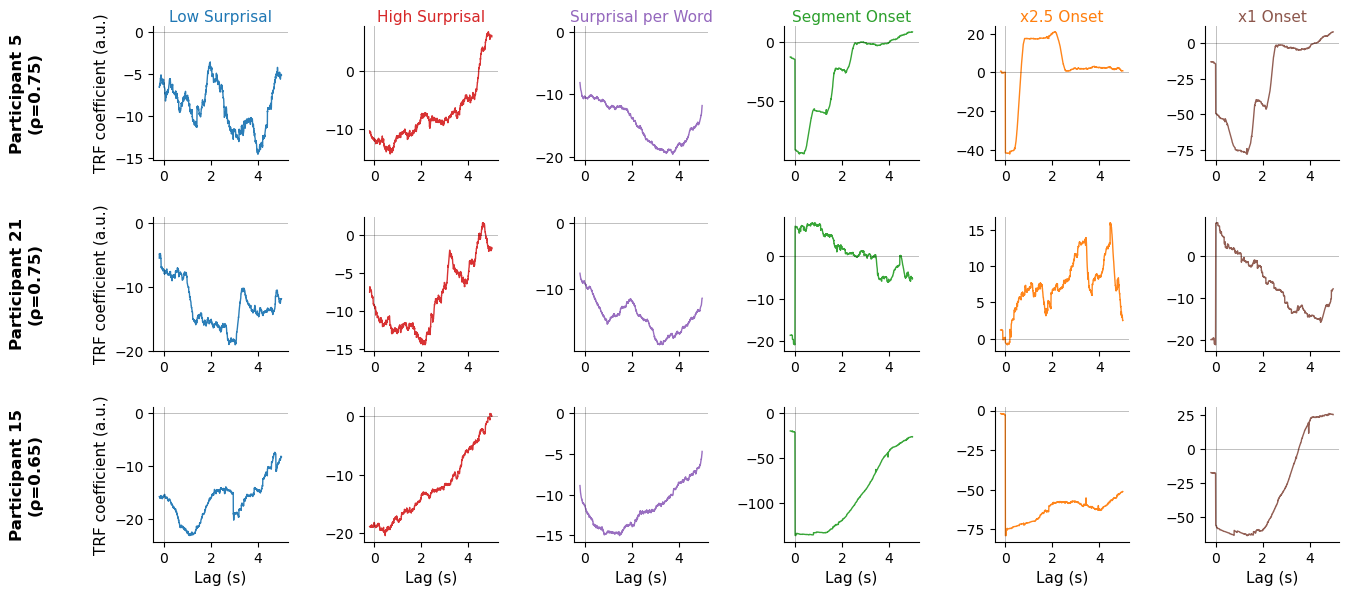

In [ ]:
# Plots for 3 participants with the highest correlation

PICKS = [5, 21, 15] 
SAVE_DIR = os.path.join(os.path.expanduser("~"), "Desktop", "experiment_3")
os.makedirs(SAVE_DIR, exist_ok=True)

TICK_FONTSIZE = 10
TITLE_FONTSIZE = 11
ROW_TITLE_FONTSIZE = 12

FIG_W_IN, FIG_H_IN = 16.0, 6.0

TIME_WSPACE = 0.25
TIME_HSPACE = 0.42
TIME_ROW_TITLE_OFFSET = 0.07  #  padding between row titles and panels
TIME_LEFT, TIME_RIGHT, TIME_TOP, TIME_BOTTOM = 0.20, 0.88, 0.96, 0.10

TRF_WSPACE = 0.28
TRF_HSPACE = 0.42
TRF_ROW_TITLE_OFFSET = 0.07  
TRF_LEFT, TRF_RIGHT, TRF_TOP, TRF_BOTTOM = 0.22, 0.98, 0.96, 0.10

feature_labels = [
    "Low Surprisal", "High Surprisal", "Surprisal per Word",
    "Segment Onset", "x2.5 Onset", "x1 Onset"
]
feature_colors = ["#1f77b4","#d62728","#9467bd","#2ca02c","#ff7f0e","#8c564b"]

HIGH_COLOR_NAME, HIGH_ALPHA = "lightgrey", 0.30
LOW_COLOR_NAME,  LOW_ALPHA  = "white",     0.30
X1_ONSET_COLOR_NAME, X25_ONSET_COLOR_NAME = "dimgray", "dimgray"
ONSET_ALPHA, ONSET_LW = 0.7, 0.8
BRACKET_Y, BRACKET_TICK, BRACKET_LW, BRACKET_FSIZE = 1.05, 0.06, 1.2, 8


def _load_story(pid):
    """Load story dict for a participant ID."""
    path = os.path.join(CFG.BASE_PATH, f"sub-{pid:02d}_trf_results_spearman.npz")
    return np.load(path, allow_pickle=True)["story"].item()

def _starts_from_csv(path, n):
    """Return indices (int) where a 1.0 starts (first column CSV), truncated to length n."""
    if not os.path.exists(path):
        return np.array([], dtype=int)
    s = pd.read_csv(path, header=None).iloc[:, 0]
    s = pd.to_numeric(s, errors="coerce").fillna(0).astype(float).to_numpy()[:n]
    return np.flatnonzero(s == 1.0)

def _shade_surprisal(ax, pid, n, sfreq):
    """Alternate span shading for contiguous high/low surprisal runs."""
    hi = _starts_from_csv(os.path.join(CFG.BASE_PATH, f"p_{pid}_total_high_surprisal_values.csv"), n)
    lo = _starts_from_csv(os.path.join(CFG.BASE_PATH, f"p_{pid}_total_low_surprisal_values.csv"),  n)

    markers = [(int(i), "high") for i in hi] + [(int(i), "low") for i in lo]
    markers.sort(key=lambda x: (x[0], 0 if x[1] == "high" else 1))

    dedup, last = [], None
    for i, lab in markers:
        if i != last:
            dedup.append((i, lab)); last = i

    for k, (start_i, lab) in enumerate(dedup):
        end_i = dedup[k+1][0] if k + 1 < len(dedup) else (n - 1)
        if end_i <= start_i:
            continue
        x0, x1 = start_i / sfreq, end_i / sfreq
        ax.axvspan(
            x0, x1,
            color=(HIGH_COLOR_NAME if lab == "high" else LOW_COLOR_NAME),
            alpha=(HIGH_ALPHA if lab == "high" else LOW_ALPHA),
            zorder=0
        )

def _onsets_and_brackets(ax, pid, n, sfreq):
    """Draw vertical onset lines and connecting brackets with labels."""
    x1  = _starts_from_csv(os.path.join(CFG.BASE_PATH, f"p_{pid}_total_story_onset.csv"), n)
    x25 = _starts_from_csv(os.path.join(CFG.BASE_PATH, f"p_{pid}_total_sped_onset.csv"),  n)
    markers = [(int(i),"x1") for i in x1] + [(int(i),"x2.5") for i in x25]
    markers.sort(key=lambda x: (x[0], 0 if x[1] == "x1" else 1))

    for i, lab in markers:
        x = i / sfreq
        col = X1_ONSET_COLOR_NAME if lab == "x1" else X25_ONSET_COLOR_NAME
        ax.axvline(x, color=col, alpha=ONSET_ALPHA, lw=ONSET_LW, zorder=2)

    if not markers:
        return

    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    # brackets 
    for k in range(len(markers) - 1):
        i0, lab = markers[k]
        i1, _   = markers[k + 1]
        if i1 <= i0:
            continue
        x0, x1 = i0 / sfreq, i1 / sfreq
        col = X1_ONSET_COLOR_NAME if lab == "x1" else X25_ONSET_COLOR_NAME
        ax.plot([x0, x1], [BRACKET_Y, BRACKET_Y], transform=trans, color=col,
                lw=BRACKET_LW, clip_on=False, zorder=3)
        ax.plot([x0, x0], [BRACKET_Y, BRACKET_Y - BRACKET_TICK], transform=trans,
                color=col, lw=BRACKET_LW, clip_on=False, zorder=3)
        ax.plot([x1, x1], [BRACKET_Y, BRACKET_Y - BRACKET_TICK], transform=trans,
                color=col, lw=BRACKET_LW, clip_on=False, zorder=3)
        ax.text((x0 + x1) / 2, BRACKET_Y + 0.008, lab, transform=trans,
                ha="center", va="bottom", fontsize=BRACKET_FSIZE,
                color=col, clip_on=False, zorder=3)

    # bracket to the end
    ilast, lablast = markers[-1]
    x0, x1 = ilast / sfreq, (n - 1) / sfreq
    if x1 > x0:
        col = X1_ONSET_COLOR_NAME if lablast == "x1" else X25_ONSET_COLOR_NAME
        ax.plot([x0, x1], [BRACKET_Y, BRACKET_Y], transform=trans, color=col,
                lw=BRACKET_LW, clip_on=False, zorder=3)
        ax.plot([x0, x0], [BRACKET_Y, BRACKET_Y - BRACKET_TICK], transform=trans,
                color=col, lw=BRACKET_LW, clip_on=False, zorder=3)
        ax.plot([x1, x1], [BRACKET_Y, BRACKET_Y - BRACKET_TICK], transform=trans,
                color=col, lw=BRACKET_LW, clip_on=False, zorder=3)
        ax.text((x0 + x1) / 2, BRACKET_Y + 0.008, lablast, transform=trans,
                ha="center", va="bottom", fontsize=BRACKET_FSIZE,
                color=col, clip_on=False, zorder=3)


n_rows = len(PICKS)
fig_time = plt.figure(figsize=(FIG_W_IN, FIG_H_IN))
gs_time = gridspec.GridSpec(
    nrows=n_rows, ncols=1, figure=fig_time,
    wspace=TIME_WSPACE, hspace=TIME_HSPACE
)
fig_time.subplots_adjust(left=TIME_LEFT, right=TIME_RIGHT, top=TIME_TOP, bottom=TIME_BOTTOM)

axes_time = []
for r, pid in enumerate(PICKS):
    story = _load_story(pid)
    y_true, y_pred = story["y_actual"], story["y_pred"]
    rho = float(story.get("mean_spearman", np.nan))
    n   = len(y_pred)
    t   = np.arange(n) / float(CFG.SFREQ)

    ax = fig_time.add_subplot(gs_time[r, 0])
    axes_time.append(ax)

    # background annotations
    _shade_surprisal(ax, pid, n, CFG.SFREQ)
    _onsets_and_brackets(ax, pid, n, CFG.SFREQ)

    # 0–1 scale slider responses
    y_true_01 = y_true.astype(float) / 255.0
    y_pred_01 = y_pred.astype(float) / 255.0
    ax.plot(t, y_true_01, lw=1.0, alpha=0.9, color="C0", label="Actual",    zorder=4)
    ax.plot(t, y_pred_01, lw=0.9, alpha=0.9, color="C1", label="Predicted", zorder=4)

    ax.axhline(0, color="k", lw=0.7, alpha=0.25)
    ax.tick_params(labelsize=TICK_FONTSIZE)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    if r == n_rows - 1:
        ax.set_xlabel("Time (s)", fontsize=TICK_FONTSIZE + 1)
    ax.set_ylabel("Slider Position", fontsize=TICK_FONTSIZE + 1)
    ax.set_ylim(-0.05, 1.05)

    # row title 
    bbox = ax.get_position(fig_time)
    fig_time.text(
        bbox.x0 - TIME_ROW_TITLE_OFFSET, (bbox.y0 + bbox.y1) / 2,
        f"Participant {pid}\n(ρ={rho:.2f})",
        ha="center", va="center",
        fontsize=ROW_TITLE_FONTSIZE, fontweight="bold", rotation=90
    )

# legend on top-right 
legend_handles = [
    Line2D([0],[0], color="C0", lw=1.2, alpha=0.9, label="Actual"),
    Line2D([0],[0], color="C1", lw=1.0, alpha=0.9, label="Predicted"),
    Patch(facecolor=HIGH_COLOR_NAME, edgecolor="0.6", alpha=HIGH_ALPHA, label="High Surprisal"),
    Patch(facecolor=LOW_COLOR_NAME,  edgecolor="0.6", alpha=LOW_ALPHA,  label="Low Surprisal"),
    Line2D([0],[0], color=X1_ONSET_COLOR_NAME, lw=ONSET_LW, alpha=ONSET_ALPHA,
           label="Speech rate (x1, x2.5)"),
]
right_edge = max(ax.get_position(fig_time).x1 for ax in axes_time)
fig_time.legend(
    handles=legend_handles,
    labels=[h.get_label() for h in legend_handles],
    loc="upper left",
    bbox_to_anchor=(right_edge + 0.012, 0.985),
    bbox_transform=fig_time.transFigure,
    frameon=False,
    fontsize=TICK_FONTSIZE,
    borderaxespad=0.0,
)

plt.show()
#fig_time.savefig(os.path.join(SAVE_DIR, "3_participants_time.svg"),
                 #format="svg", bbox_inches="tight")
plt.close(fig_time)

# 2nd figure; TRF coefficients

fig_trf = plt.figure(figsize=(FIG_W_IN, FIG_H_IN))
gs_trf = gridspec.GridSpec(
    nrows=n_rows, ncols=6, figure=fig_trf,
    wspace=TRF_WSPACE, hspace=TRF_HSPACE
)
fig_trf.subplots_adjust(left=TRF_LEFT, right=TRF_RIGHT, top=TRF_TOP, bottom=TRF_BOTTOM)

for r, pid in enumerate(PICKS):
    story = _load_story(pid)
    rho   = float(story.get("mean_spearman", np.nan))
    coefs = story["mean_coefs"].squeeze(0)  # (6, T)
    times = story["times"]

    row_first_ax = None
    for fi in range(6):
        ax = fig_trf.add_subplot(gs_trf[r, fi])
        if fi == 0:
            row_first_ax = ax  

        ax.set_box_aspect(1)
        ax.plot(times, coefs[fi], lw=1.0, alpha=0.95, color=feature_colors[fi])
        ax.axhline(0, color="k", lw=0.7, alpha=0.25)
        ax.axvline(0, color="k", lw=0.7, alpha=0.25)
        ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
        ax.tick_params(labelsize=TICK_FONTSIZE)

        if r == 0:
            ax.set_title(feature_labels[fi], fontsize=TITLE_FONTSIZE,
                         color=feature_colors[fi], pad=3)
        if r == n_rows - 1:
            ax.set_xlabel("Lag (s)", fontsize=TICK_FONTSIZE + 1)
        if fi == 0:
            ax.set_ylabel("TRF coefficient (a.u.)", fontsize=TICK_FONTSIZE + 1)

    # row title 
    bbox = row_first_ax.get_position(fig_trf)
    fig_trf.text(
        bbox.x0 - TRF_ROW_TITLE_OFFSET, (bbox.y0 + bbox.y1) / 2,
        f"Participant {pid}\n(ρ={rho:.2f})",
        ha="center", va="center",
        fontsize=ROW_TITLE_FONTSIZE, fontweight="bold", rotation=90
    )

plt.show()
#fig_trf.savefig(os.path.join(SAVE_DIR, "3_participants_trf.svg"),
                #format="svg", bbox_inches="tight")
plt.close(fig_trf)


# Model Comprarions- TRF without surprise features

In [ ]:
INCLUDE_IDX = [3, 4, 5]  # drop the three surprisal-related features

def _make_rf_custom(n_features: int, cfg=CFG) -> ReceptiveField:
    """Create an MNE ReceptiveField with cfg and a custom feature count."""
    #  names only for the features we actually include,
    included_names = [list(cfg.FEATURE_NAMES)[i] for i in INCLUDE_IDX]
    return ReceptiveField(
        tmin=cfg.TMIN,
        tmax=cfg.TMAX,
        sfreq=cfg.SFREQ,
        feature_names=included_names,
        estimator=1.0,       # alpha
        scoring="corrcoef",  
    )

def _load_features_subset(pid: int, cfg=CFG) -> np.ndarray:
    """Load all 6 features and return only the selected subset (n_feat, T)."""
    
    suffixes = [
        "_total_low_surprisal_values.csv",
        "_total_high_surprisal_values.csv",
        "_total_surprisal_values.csv",
        "_total_file_onset.csv",
        "_total_sped_onset.csv",
        "_total_story_onset.csv",
    ]
    feats, L = [], []
    for suf in suffixes:
        f = os.path.join(cfg.BASE_PATH, f"p_{pid}{suf}")
        if not os.path.exists(f):
            raise FileNotFoundError(f"Missing {f}")
        s = pd.read_csv(f, header=None).iloc[:, 0]
        s = pd.to_numeric(s, errors="coerce").fillna(0).astype(float).to_numpy()
        feats.append(s)
        L.append(len(s))
    T = min(L)
    feats = [s[:T] for s in feats]
    X = np.vstack(feats)            
    X = X[INCLUDE_IDX, :]           # keep only non-surprisal features
    return X                   

def _load_slider_as_raw(pid: int, cfg=CFG):
    """Read your slider CSV into a 1-ch RawArray."""
    path = os.path.join(cfg.BASE_PATH, f"p_{pid}_total_combine.csv")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing slider file {path}")
    df = pd.read_csv(path)
    vals = pd.to_numeric(df["value"], errors="coerce").dropna().astype(float).to_numpy()
    info = mne.create_info(ch_names=["slider"], sfreq=cfg.SFREQ, ch_types=["misc"])
    return mne.io.RawArray(vals[None, :], info, verbose="ERROR")

def fit_trf_no_surprisal(pid: int, cfg=CFG) -> Optional[dict]:
    """Fit TRF using ONLY non-surprisal features; return same dict layout as before."""
    try:
        X = _load_features_subset(pid, cfg)   
        raw = _load_slider_as_raw(pid, cfg)   
    except FileNotFoundError as e:
        print(f"[p_{pid}] {e} — skipping.")
        return None

    T = min(X.shape[1], raw.n_times)
    X = X[:, :T].T        # (T, n_feat)
    y, _ = raw[:]
    y = y.T               # (T, 1)

    # 3 folds, no shuffle 
    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=False)

    spearmans = []
    coef_list, yhat_cat, ytrue_cat = [], [], []

    # Helper to run a full CV pass and report fold Spearman ρ list
    def run_cv(kf_obj) -> Tuple[List[float], List[np.ndarray], List[np.ndarray], List[np.ndarray], np.ndarray]:
        _rhos, _coef_list, _yhat_cat, _ytrue_cat = [], [], [], []
        rf_local = None
        for fold, (tr, te) in enumerate(kf_obj.split(X), 1):
            rf_local = _make_rf_custom(X.shape[1], cfg)
            rf_local.fit(X[tr], y[tr])
            yhat = rf_local.predict(X[te])
            rho = float(stats.spearmanr(y[te].ravel(), yhat.ravel(), nan_policy="omit").statistic)
            print(f"[p_{pid}] fold {fold}/{kf_obj.n_splits}: Spearman ρ={rho:.3f}")
            _rhos.append(rho)
            _yhat_cat.append(yhat.ravel())
            _ytrue_cat.append(y[te].ravel())
            _coef_list.append(rf_local.coef_)
        return _rhos, _coef_list, _yhat_cat, _ytrue_cat, rf_local

    # first pass (3 folds)
    rhos, coef_list, yhat_cat, ytrue_cat, rf_last = run_cv(kf)

    # fallback to 2 folds if any fold produced NaN
    if any(np.isnan(r) for r in rhos):
        print(f"[p_{pid}] NaN Spearman in 3-fold CV → re-running with 2 folds.")
        kf2 = KFold(n_splits=2, shuffle=False)
        rhos, coef_list, yhat_cat, ytrue_cat, rf_last = run_cv(kf2)

    coefs = np.stack(coef_list, axis=0)     # (k, 1, n_feat, n_delays)
    mean_coefs = np.mean(coefs, axis=0)     # (1, n_feat, n_delays)
    times = rf_last.delays_ / float(rf_last.sfreq)

    good = [r for r in rhos if not np.isnan(r)]
    mean_spearman = float(np.mean(good)) if good else np.nan

    return dict(
        mean_coefs=mean_coefs,
        mean_scores=mean_spearman,  # same key but value is Spearman
        times=times,
        y_pred=np.concatenate(yhat_cat),
        y_actual=np.concatenate(ytrue_cat),
        mean_spearman=mean_spearman,
    )

def save_no_surprisal(pid: int, res: dict, cfg=CFG) -> str:
    """Save into a separate file to avoid overwriting your originals."""
    sub_id = f"sub-{pid:02d}"
    out = os.path.join(cfg.BASE_PATH, f"{sub_id}_trf_results_NO_SURPRISAL.npz")
    np.savez(out, story=res)
    print(f"[p_{pid}] saved → {out}")
    return out

# batch run over participants 
done = []
for pid in sorted(set(int(p) for p in completed)):
    res = fit_trf_no_surprisal(pid, CFG)
    if res is not None:
        save_no_surprisal(pid, res, CFG)
        done.append(pid)

print("Completed (no-surprisal) participants:", done)

Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_1] fold 1/3: Spearman ρ=0.172
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_1] fold 2/3: Spearman ρ=0.154
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_1] fold 3/3: Spearman ρ=0.236
[p_1] saved → /Users/irmakergin/Desktop/TRF/sub-01_trf_results_NO_SURPRISAL.npz
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_3] fold 1/3: Spearman ρ=0.337
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_3] fold 2/3: Spearman ρ=0.265
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_3] fold 3/3: Spearman ρ=0.170
[p_3] saved → /Users/irmakergin/Desktop/TRF/sub-03_trf_results_NO_SURPRISAL.npz
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_4] fold 1/3: Spearman ρ=0.232
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_4] fold 2/3: Spearman ρ=0.530
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_4] fold 3/3: Spearman ρ=0.241
[p_4] saved → /Users/irmakergin/Desktop/TRF/sub-04_trf_results_NO_SURPRISAL.npz
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_5] fold 1/3: Spearman ρ=0.107
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_5] fold 2/3: Spearman ρ=0.070
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_5] fold 3/3: Spearman ρ=nan
[p_5] NaN Spearman in 3-fold CV → re-running with 2 folds.
Fitting 1 epochs, 3 channels


/var/folders/ns/z1dmbny9559fnq9zm5zly5cr0000gn/T/ipykernel_31508/817311540.py:81: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho = float(stats.spearmanr(y[te].ravel(), yhat.ravel(), nan_policy="omit").statistic)


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_5] fold 1/2: Spearman ρ=0.090
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_5] fold 2/2: Spearman ρ=0.084
[p_5] saved → /Users/irmakergin/Desktop/TRF/sub-05_trf_results_NO_SURPRISAL.npz
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_6] fold 1/3: Spearman ρ=0.103
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_6] fold 2/3: Spearman ρ=0.093
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_6] fold 3/3: Spearman ρ=nan
[p_6] NaN Spearman in 3-fold CV → re-running with 2 folds.
Fitting 1 epochs, 3 channels


/var/folders/ns/z1dmbny9559fnq9zm5zly5cr0000gn/T/ipykernel_31508/817311540.py:81: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho = float(stats.spearmanr(y[te].ravel(), yhat.ravel(), nan_policy="omit").statistic)


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_6] fold 1/2: Spearman ρ=0.035
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_6] fold 2/2: Spearman ρ=0.505
[p_6] saved → /Users/irmakergin/Desktop/TRF/sub-06_trf_results_NO_SURPRISAL.npz
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_7] fold 1/3: Spearman ρ=0.501
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_7] fold 2/3: Spearman ρ=0.238
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_7] fold 3/3: Spearman ρ=0.218
[p_7] saved → /Users/irmakergin/Desktop/TRF/sub-07_trf_results_NO_SURPRISAL.npz
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_8] fold 1/3: Spearman ρ=0.199
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_8] fold 2/3: Spearman ρ=0.213
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_8] fold 3/3: Spearman ρ=nan
[p_8] NaN Spearman in 3-fold CV → re-running with 2 folds.
Fitting 1 epochs, 3 channels


/var/folders/ns/z1dmbny9559fnq9zm5zly5cr0000gn/T/ipykernel_31508/817311540.py:81: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho = float(stats.spearmanr(y[te].ravel(), yhat.ravel(), nan_policy="omit").statistic)


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_8] fold 1/2: Spearman ρ=0.217
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_8] fold 2/2: Spearman ρ=0.188
[p_8] saved → /Users/irmakergin/Desktop/TRF/sub-08_trf_results_NO_SURPRISAL.npz
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_9] fold 1/3: Spearman ρ=0.275
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_9] fold 2/3: Spearman ρ=0.021
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_9] fold 3/3: Spearman ρ=0.321
[p_9] saved → /Users/irmakergin/Desktop/TRF/sub-09_trf_results_NO_SURPRISAL.npz
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_10] fold 1/3: Spearman ρ=0.256
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_10] fold 2/3: Spearman ρ=0.132
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_10] fold 3/3: Spearman ρ=0.061
[p_10] saved → /Users/irmakergin/Desktop/TRF/sub-10_trf_results_NO_SURPRISAL.npz
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_11] fold 1/3: Spearman ρ=0.688
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_11] fold 2/3: Spearman ρ=0.212
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_11] fold 3/3: Spearman ρ=0.224
[p_11] saved → /Users/irmakergin/Desktop/TRF/sub-11_trf_results_NO_SURPRISAL.npz
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_12] fold 1/3: Spearman ρ=0.375
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_12] fold 2/3: Spearman ρ=nan
Fitting 1 epochs, 3 channels


/var/folders/ns/z1dmbny9559fnq9zm5zly5cr0000gn/T/ipykernel_31508/817311540.py:81: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho = float(stats.spearmanr(y[te].ravel(), yhat.ravel(), nan_policy="omit").statistic)


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_12] fold 3/3: Spearman ρ=0.257
[p_12] NaN Spearman in 3-fold CV → re-running with 2 folds.
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_12] fold 1/2: Spearman ρ=0.308
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_12] fold 2/2: Spearman ρ=0.295
[p_12] saved → /Users/irmakergin/Desktop/TRF/sub-12_trf_results_NO_SURPRISAL.npz
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_14] fold 1/3: Spearman ρ=0.248
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_14] fold 2/3: Spearman ρ=0.297
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_14] fold 3/3: Spearman ρ=nan
[p_14] NaN Spearman in 3-fold CV → re-running with 2 folds.
Fitting 1 epochs, 3 channels


/var/folders/ns/z1dmbny9559fnq9zm5zly5cr0000gn/T/ipykernel_31508/817311540.py:81: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho = float(stats.spearmanr(y[te].ravel(), yhat.ravel(), nan_policy="omit").statistic)


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_14] fold 1/2: Spearman ρ=0.323
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_14] fold 2/2: Spearman ρ=0.279
[p_14] saved → /Users/irmakergin/Desktop/TRF/sub-14_trf_results_NO_SURPRISAL.npz
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_15] fold 1/3: Spearman ρ=0.506
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_15] fold 2/3: Spearman ρ=0.195
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_15] fold 3/3: Spearman ρ=0.181
[p_15] saved → /Users/irmakergin/Desktop/TRF/sub-15_trf_results_NO_SURPRISAL.npz
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_16] fold 1/3: Spearman ρ=0.004
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_16] fold 2/3: Spearman ρ=0.073
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_16] fold 3/3: Spearman ρ=0.050
[p_16] saved → /Users/irmakergin/Desktop/TRF/sub-16_trf_results_NO_SURPRISAL.npz
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_18] fold 1/3: Spearman ρ=0.032
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_18] fold 2/3: Spearman ρ=nan
Fitting 1 epochs, 3 channels


/var/folders/ns/z1dmbny9559fnq9zm5zly5cr0000gn/T/ipykernel_31508/817311540.py:81: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho = float(stats.spearmanr(y[te].ravel(), yhat.ravel(), nan_policy="omit").statistic)


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_18] fold 3/3: Spearman ρ=0.297
[p_18] NaN Spearman in 3-fold CV → re-running with 2 folds.
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_18] fold 1/2: Spearman ρ=0.124
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_18] fold 2/2: Spearman ρ=0.214
[p_18] saved → /Users/irmakergin/Desktop/TRF/sub-18_trf_results_NO_SURPRISAL.npz
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_19] fold 1/3: Spearman ρ=-0.001
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_19] fold 2/3: Spearman ρ=nan
Fitting 1 epochs, 3 channels


/var/folders/ns/z1dmbny9559fnq9zm5zly5cr0000gn/T/ipykernel_31508/817311540.py:81: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho = float(stats.spearmanr(y[te].ravel(), yhat.ravel(), nan_policy="omit").statistic)


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_19] fold 3/3: Spearman ρ=0.121
[p_19] NaN Spearman in 3-fold CV → re-running with 2 folds.
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_19] fold 1/2: Spearman ρ=-0.001
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_19] fold 2/2: Spearman ρ=0.008
[p_19] saved → /Users/irmakergin/Desktop/TRF/sub-19_trf_results_NO_SURPRISAL.npz
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_20] fold 1/3: Spearman ρ=0.265
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_20] fold 2/3: Spearman ρ=0.244
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_20] fold 3/3: Spearman ρ=0.205
[p_20] saved → /Users/irmakergin/Desktop/TRF/sub-20_trf_results_NO_SURPRISAL.npz
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_21] fold 1/3: Spearman ρ=0.100
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_21] fold 2/3: Spearman ρ=nan
Fitting 1 epochs, 3 channels


/var/folders/ns/z1dmbny9559fnq9zm5zly5cr0000gn/T/ipykernel_31508/817311540.py:81: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho = float(stats.spearmanr(y[te].ravel(), yhat.ravel(), nan_policy="omit").statistic)


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_21] fold 3/3: Spearman ρ=0.065
[p_21] NaN Spearman in 3-fold CV → re-running with 2 folds.
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_21] fold 1/2: Spearman ρ=0.045
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_21] fold 2/2: Spearman ρ=0.107
[p_21] saved → /Users/irmakergin/Desktop/TRF/sub-21_trf_results_NO_SURPRISAL.npz
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_22] fold 1/3: Spearman ρ=nan
Fitting 1 epochs, 3 channels


/var/folders/ns/z1dmbny9559fnq9zm5zly5cr0000gn/T/ipykernel_31508/817311540.py:81: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho = float(stats.spearmanr(y[te].ravel(), yhat.ravel(), nan_policy="omit").statistic)


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_22] fold 2/3: Spearman ρ=nan
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_22] fold 3/3: Spearman ρ=nan
[p_22] NaN Spearman in 3-fold CV → re-running with 2 folds.
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_22] fold 1/2: Spearman ρ=nan
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_22] fold 2/2: Spearman ρ=nan
[p_22] saved → /Users/irmakergin/Desktop/TRF/sub-22_trf_results_NO_SURPRISAL.npz
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_23] fold 1/3: Spearman ρ=0.335
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_23] fold 2/3: Spearman ρ=0.303
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_23] fold 3/3: Spearman ρ=nan
[p_23] NaN Spearman in 3-fold CV → re-running with 2 folds.
Fitting 1 epochs, 3 channels


/var/folders/ns/z1dmbny9559fnq9zm5zly5cr0000gn/T/ipykernel_31508/817311540.py:81: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho = float(stats.spearmanr(y[te].ravel(), yhat.ravel(), nan_policy="omit").statistic)


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_23] fold 1/2: Spearman ρ=0.277
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_23] fold 2/2: Spearman ρ=0.330
[p_23] saved → /Users/irmakergin/Desktop/TRF/sub-23_trf_results_NO_SURPRISAL.npz
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_24] fold 1/3: Spearman ρ=0.053
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_24] fold 2/3: Spearman ρ=0.197
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_24] fold 3/3: Spearman ρ=nan
[p_24] NaN Spearman in 3-fold CV → re-running with 2 folds.
Fitting 1 epochs, 3 channels


/var/folders/ns/z1dmbny9559fnq9zm5zly5cr0000gn/T/ipykernel_31508/817311540.py:81: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho = float(stats.spearmanr(y[te].ravel(), yhat.ravel(), nan_policy="omit").statistic)


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_24] fold 1/2: Spearman ρ=0.100
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_24] fold 2/2: Spearman ρ=0.018
[p_24] saved → /Users/irmakergin/Desktop/TRF/sub-24_trf_results_NO_SURPRISAL.npz
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_26] fold 1/3: Spearman ρ=0.091
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_26] fold 2/3: Spearman ρ=0.094
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_26] fold 3/3: Spearman ρ=nan
[p_26] NaN Spearman in 3-fold CV → re-running with 2 folds.
Fitting 1 epochs, 3 channels


/var/folders/ns/z1dmbny9559fnq9zm5zly5cr0000gn/T/ipykernel_31508/817311540.py:81: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho = float(stats.spearmanr(y[te].ravel(), yhat.ravel(), nan_policy="omit").statistic)


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_26] fold 1/2: Spearman ρ=0.078
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_26] fold 2/2: Spearman ρ=0.140
[p_26] saved → /Users/irmakergin/Desktop/TRF/sub-26_trf_results_NO_SURPRISAL.npz
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_27] fold 1/3: Spearman ρ=0.333
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_27] fold 2/3: Spearman ρ=0.237
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_27] fold 3/3: Spearman ρ=0.205
[p_27] saved → /Users/irmakergin/Desktop/TRF/sub-27_trf_results_NO_SURPRISAL.npz
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_28] fold 1/3: Spearman ρ=0.179
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_28] fold 2/3: Spearman ρ=0.257
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_28] fold 3/3: Spearman ρ=0.153
[p_28] saved → /Users/irmakergin/Desktop/TRF/sub-28_trf_results_NO_SURPRISAL.npz
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_29] fold 1/3: Spearman ρ=0.199
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_29] fold 2/3: Spearman ρ=0.011
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_29] fold 3/3: Spearman ρ=0.130
[p_29] saved → /Users/irmakergin/Desktop/TRF/sub-29_trf_results_NO_SURPRISAL.npz
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_30] fold 1/3: Spearman ρ=0.061
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_30] fold 2/3: Spearman ρ=0.080
Fitting 1 epochs, 3 channels


  0%|          | Sample : 0/9 [00:00<?,       ?it/s]

[p_30] fold 3/3: Spearman ρ=0.078
[p_30] saved → /Users/irmakergin/Desktop/TRF/sub-30_trf_results_NO_SURPRISAL.npz
Completed (no-surprisal) participants: [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30]


In [ ]:
with_scores = {}
no_scores   = {}
BASE = CFG.BASE_PATH

# load "with surprisal"
for name in sorted(os.listdir(BASE)):
    if name.startswith("sub-") and name.endswith("_trf_results_spearman.npz"):
        pid = int(name[4:6])
        d = np.load(os.path.join(BASE, name), allow_pickle=True)["story"].item()
        r = float(d.get("mean_spearman", np.nan))
        if not np.isnan(r):
            with_scores[pid] = r

# load "without surprisal"
for name in sorted(os.listdir(BASE)):
    if name.startswith("sub-") and name.endswith("_trf_results_NO_SURPRISAL.npz"):
        pid = int(name[4:6])
        d = np.load(os.path.join(BASE, name), allow_pickle=True)["story"].item()
        r = float(d.get("mean_spearman", np.nan))
        if not np.isnan(r):
            no_scores[pid] = r

common_pids = sorted(set(with_scores.keys()) & set(no_scores.keys()))
if not common_pids:
    raise RuntimeError("No overlapping participants with both models found.")

w = np.array([with_scores[p] for p in common_pids], dtype=float)
n = np.array([no_scores[p]   for p in common_pids], dtype=float)
diff = w - n  # positive means = surprisal correlates higher
# who improved / worsened / no change (by participant ID)
improved_idx  = np.where(diff > 0)[0]
worsened_idx  = np.where(diff < 0)[0]
nochange_idx  = np.where(diff == 0)[0]

print("Improved (WITH > WITHOUT):",  [common_pids[i] for i in improved_idx])
print("Worsened (WITH < WITHOUT):",  [common_pids[i] for i in worsened_idx])
print("No change (WITH = WITHOUT):", [common_pids[i] for i in nochange_idx])

# Paired t-test on difference
t_stat, p_val = stats.ttest_rel(w, n, nan_policy="omit")
N = len(diff)
mean_w = float(np.mean(w));   mean_n = float(np.mean(n))
mean_d = float(np.mean(diff)); sd_d = float(np.std(diff, ddof=1)) if N > 1 else 0.0
se_d   = sd_d / np.sqrt(N) if N > 0 else np.nan

# 95% CI for the mean difference
if N > 1:
    tcrit = stats.t.ppf(0.975, df=N-1)
    ci_lo, ci_hi = mean_d - tcrit * se_d, mean_d + tcrit * se_d
else:
    ci_lo, ci_hi = np.nan, np.nan

# Cohen's d
cohens_d = mean_d / sd_d if sd_d > 0 else np.nan

# % of participants 
helped = int(np.sum(diff > 0))
hurt   = int(np.sum(diff < 0))
same   = int(np.sum(diff == 0))

print(f"Participants compared (n={N}): {common_pids}")
print(f"Mean ρ WITH surprisal     = {mean_w:.2f}")
print(f"Mean ρ WITHOUT surprisal  = {mean_n:.2f}")
print(f"Mean Δρ (WITH - WITHOUT)  = {mean_d:.2f}")
print(f"Paired t({N-1}) = {t_stat:.3f}, p = {p_val:.2f}")
print(f"95% CI of Δρ = [{ci_lo:.2f}, {ci_hi:.2f}]")
print(f"Cohen's dz = {cohens_dz:.2f}")
print(f"Improved: {helped} | Worse: {hurt} | No change: {same}")

Improved (WITH > WITHOUT): [1, 4, 5, 7, 8, 10, 11, 14, 15, 16, 20, 21, 23, 24, 26, 27, 28, 29, 30]
Worsened (WITH < WITHOUT): [3, 6, 9, 12, 18, 19]
No change (WITH = WITHOUT): []
Participants compared (n=25): [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21, 23, 24, 26, 27, 28, 29, 30]
Mean ρ WITH surprisal     = 0.37
Mean ρ WITHOUT surprisal  = 0.20
Mean Δρ (WITH - WITHOUT)  = 0.18
Paired t(24) = 2.712, p = 0.01
95% CI of Δρ = [0.04, 0.31]
Cohen's dz = 0.54
Improved: 19 | Worse: 6 | No change: 0


Participants requested: 26 | unique: 26


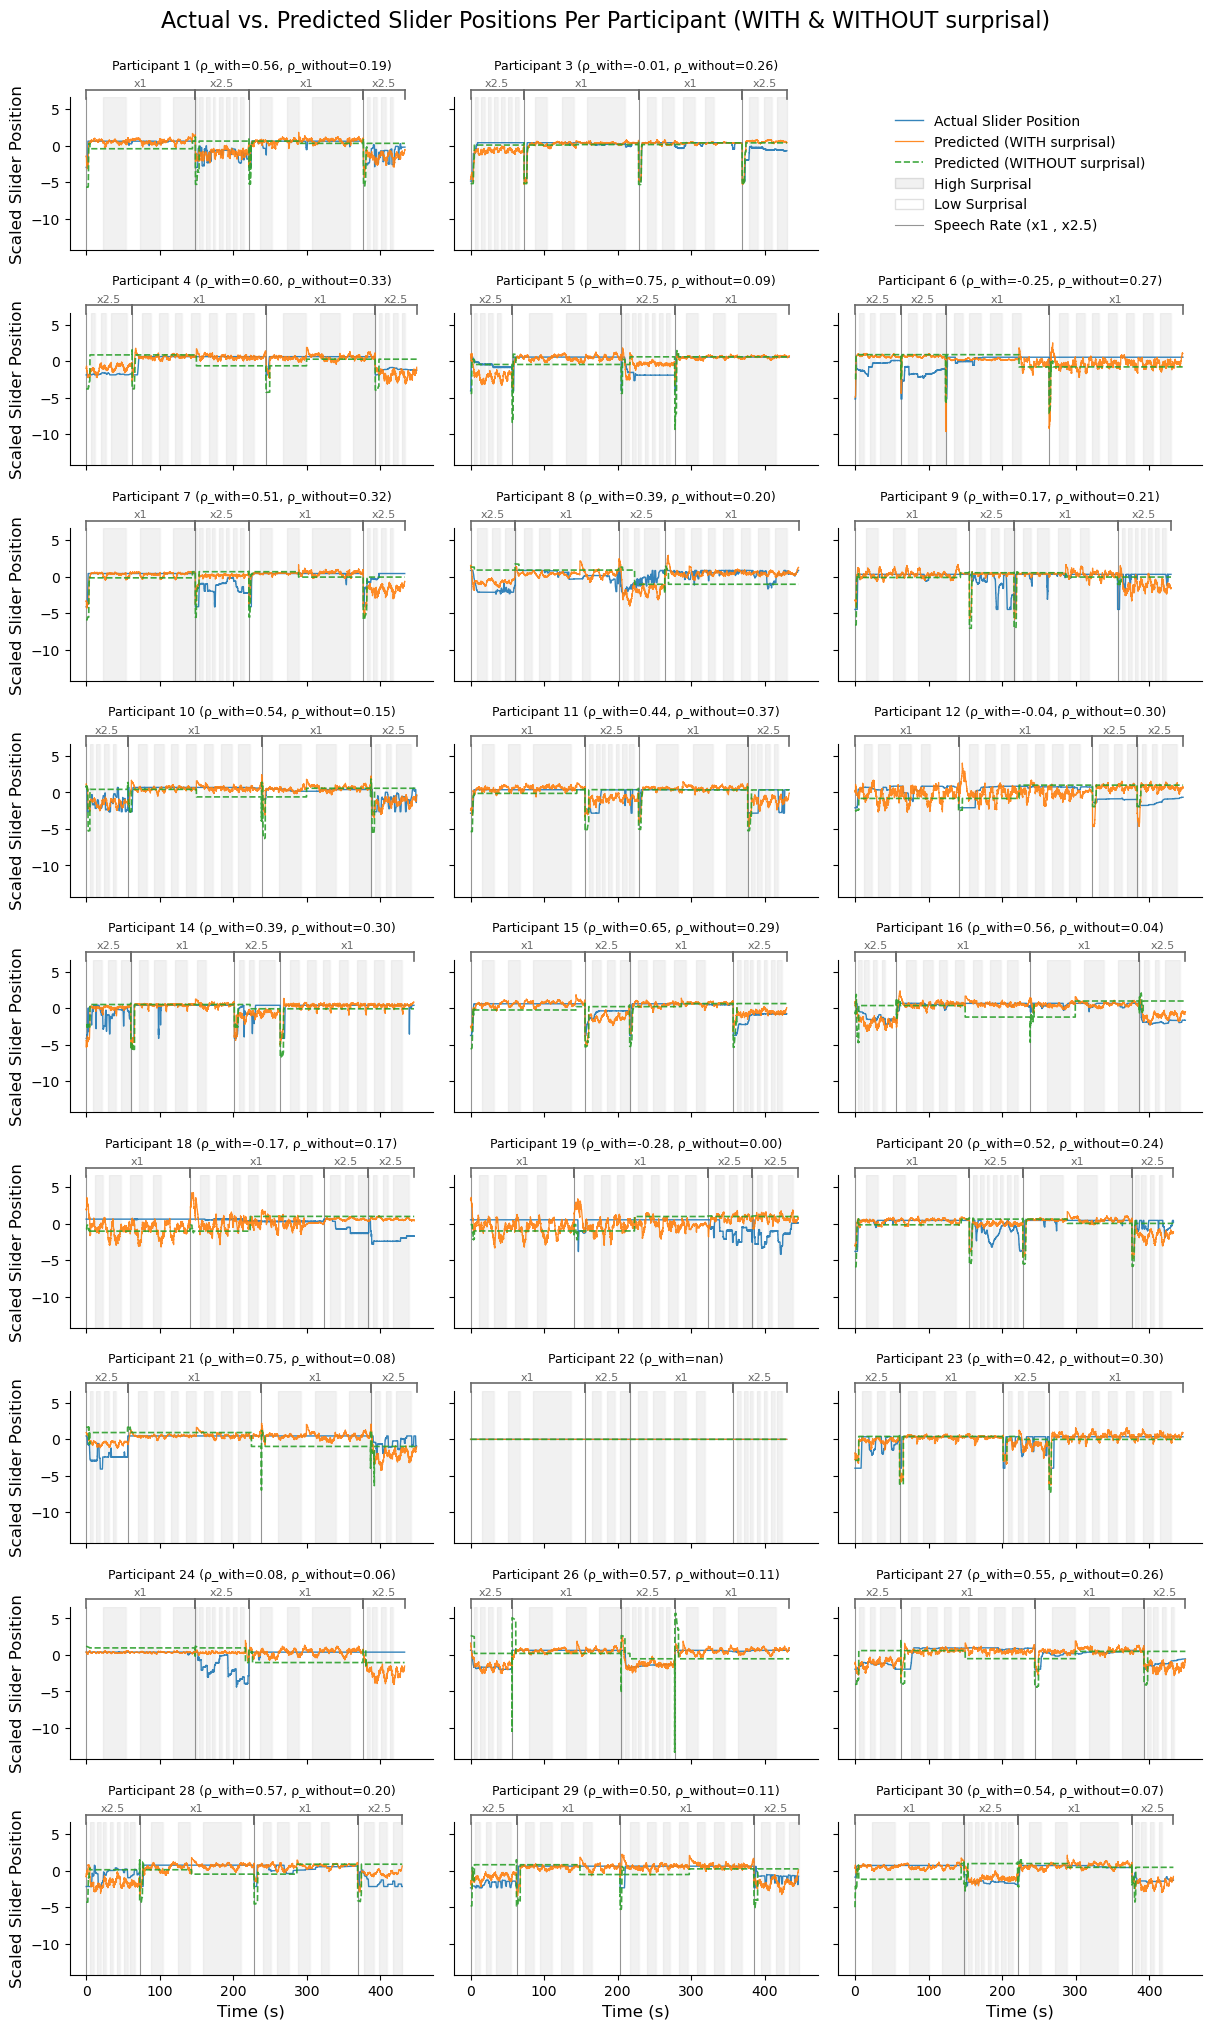

In [ ]:
# Plot predicted slider values with and without surprisal


WITH_SUFFIX     = "_trf_results_spearman.npz"   # with surprisal
WITHOUT_SUFFIX  = "_trf_results_NO_SURPRISAL.npz"  # wihout surprisal

HIGH_COLOR_NAME = "lightgrey"  # high surprisal background
HIGH_ALPHA      = 0.30
LOW_COLOR_NAME  = "white"      # low surprisal background
LOW_ALPHA       = 0.30

X1_ONSET_COLOR_NAME   = "dimgray"  # x1 onsets
X25_ONSET_COLOR_NAME  = "dimgray"  # x2.5 onsets (same tone by request)
ONSET_ALPHA           = 0.7
ONSET_LW              = 0.8

# bracket placement 
BRACKET_Y     = 1.05   
BRACKET_TICK  = 0.06
BRACKET_LW    = 1.2
BRACKET_FSIZE = 8

# sort participants
pids_raw = list(completed)
pids = sorted(set(int(pid) for pid in pids_raw))
dupe_count = len(pids_raw) - len(pids)
print(f"Participants requested: {len(pids_raw)} | unique: {len(pids)}"
      + (f" | removed duplicates: {dupe_count}" if dupe_count > 0 else ""))

# gid and page
n_rows, n_cols = 9, 3
legend_idx = 2  
per_page_total = n_rows * n_cols
per_page_effective = per_page_total - 1 
num_pages = math.ceil(len(pids) / per_page_effective) if pids else 0

# legend
legend_handles = [
    Line2D([0], [0], lw=1.0, alpha=0.9, color='C0', label='Actual Slider Position'),
    Line2D([0], [0], lw=0.9, alpha=0.9, color='C1', label='Predicted (WITH surprisal)'),
    Line2D([0], [0], lw=1.2, alpha=0.9, color='C2', linestyle='--', label='Predicted (WITHOUT surprisal)'),
    Patch(facecolor=HIGH_COLOR_NAME, edgecolor='0.6', alpha=HIGH_ALPHA, label='High Surprisal'),
    Patch(facecolor=LOW_COLOR_NAME,  edgecolor='0.6', alpha=LOW_ALPHA,  label='Low Surprisal'),
    Line2D([0], [0], lw=ONSET_LW, alpha=ONSET_ALPHA, color=X1_ONSET_COLOR_NAME,  label='Speech Rate (x1 , x2.5)'),
]

# plot pages
for page in range(num_pages):
    start = page * per_page_effective
    end   = min(start + per_page_effective, len(pids))
    batch = pids[start:end]

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(n_cols * 4.0, n_rows * 2.2),
        sharex=True, sharey=True,
        layout="constrained"
    )
    try:
        fig.set_constrained_layout_pads(w_pad=0.04, h_pad=0.10, hspace=0.06, wspace=0.04)
    except Exception:
        pass

    axes = axes.ravel()

    # legend 
    axes[legend_idx].axis("off")
    axes[legend_idx].legend(
        handles=legend_handles,
        loc="center",
        frameon=False,
        fontsize=10,
        title=""
    )
    # don't plot on the legend grid
    plot_axes = [ax for i, ax in enumerate(axes) if i != legend_idx]

    # plot each participant
    for ax, pid in zip(plot_axes, batch):
        sub_id = f"sub-{pid:02d}"
        with_path = os.path.join(CFG.BASE_PATH, f"{sub_id}{WITH_SUFFIX}")
        without_path = os.path.join(CFG.BASE_PATH, f"{sub_id}{WITHOUT_SUFFIX}")

        if not os.path.exists(with_path):
            ax.text(0.5, 0.5, f"Participant {pid}\nmissing WITH file", ha="center", va="center",
                    transform=ax.transAxes)
            ax.set_axis_off()
            continue
        
        # with suprisal
        story_with = np.load(with_path, allow_pickle=True)["story"].item()
        y_pred_with = np.asarray(story_with["y_pred"], dtype=float)
        y_true      = np.asarray(story_with["y_actual"], dtype=float)
        rho_with    = float(story_with.get("mean_spearman", np.nan))
        # without surprisal
        has_without = os.path.exists(without_path)
        if has_without:
            try:
                story_without = np.load(without_path, allow_pickle=True)["story"].item()
                y_pred_without = np.asarray(story_without["y_pred"], dtype=float)
                rho_without    = float(story_without.get("mean_spearman", np.nan))
            except Exception:
                has_without = False
                y_pred_without = None
                rho_without = np.nan
        else:
            y_pred_without = None
            rho_without = np.nan

        # align lengths (trim to min)
        n = len(y_pred_with)
        if has_without:
            n = min(n, len(y_pred_without))
        n = min(n, len(y_true))
        y_true      = y_true[:n]
        y_pred_with = y_pred_with[:n]
        if has_without:
            y_pred_without = y_pred_without[:n]

        t = np.arange(n) / CFG.SFREQ  # seconds

        # surprisal shading 
        hi_val_path = os.path.join(CFG.BASE_PATH, f"p_{pid}_total_high_surprisal_values.csv")
        lo_val_path = os.path.join(CFG.BASE_PATH, f"p_{pid}_total_low_surprisal_values.csv")

        hi_idx, lo_idx = [], []
        if os.path.exists(hi_val_path):
            s = pd.read_csv(hi_val_path, header=None).iloc[:, 0]
            s = pd.to_numeric(s, errors="coerce").fillna(0).astype(float).to_numpy()[:n]
            hi_idx = np.flatnonzero(s == 1.0)
        else:
            print(f"[p_{pid}] WARNING: missing high-surprisal file → {hi_val_path}")

        if os.path.exists(lo_val_path):
            s = pd.read_csv(lo_val_path, header=None).iloc[:, 0]
            s = pd.to_numeric(s, errors="coerce").fillna(0).astype(float).to_numpy()[:n]
            lo_idx = np.flatnonzero(s == 1.0)
        else:
            print(f"[p_{pid}] WARNING: missing low-surprisal file → {lo_val_path}")

        
        markers_surprisal = [(int(i), "high") for i in hi_idx] + [(int(i), "low") for i in lo_idx]
        markers_surprisal.sort(key=lambda x: (x[0], 0 if x[1] == "high" else 1))
        dedup = []
        last_i = None
        for i_idx, lab in markers_surprisal:
            if i_idx != last_i:
                dedup.append((i_idx, lab))
                last_i = i_idx
        markers_surprisal = dedup

        for k, (start_i, lab) in enumerate(markers_surprisal):
            end_i = markers_surprisal[k + 1][0] if k + 1 < len(markers_surprisal) else (n - 1)
            if end_i <= start_i:
                continue
            x0, x1 = start_i / CFG.SFREQ, end_i / CFG.SFREQ
            ax.axvspan(
                x0, x1,
                color=(HIGH_COLOR_NAME if lab == "high" else LOW_COLOR_NAME),
                alpha=(HIGH_ALPHA if lab == "high" else LOW_ALPHA),
                zorder=0
            )

        # story onsets (x1 / x2.5) and brackets 
        story_on_path = os.path.join(CFG.BASE_PATH, f"p_{pid}_total_story_onset.csv")  # x1 onsets
        sped_on_path  = os.path.join(CFG.BASE_PATH, f"p_{pid}_total_sped_onset.csv")   # x2.5 onsets

        x1_idx, x25_idx = [], []
        if os.path.exists(story_on_path):
            s = pd.read_csv(story_on_path, header=None).iloc[:, 0]
            s = pd.to_numeric(s, errors="coerce").fillna(0).astype(float).to_numpy()[:n]
            x1_idx = np.flatnonzero(s == 1.0)
        else:
            print(f"[p_{pid}] WARNING: missing x1 onset file → {story_on_path}")

        if os.path.exists(sped_on_path):
            s = pd.read_csv(sped_on_path, header=None).iloc[:, 0]
            s = pd.to_numeric(s, errors="coerce").fillna(0).astype(float).to_numpy()[:n]
            x25_idx = np.flatnonzero(s == 1.0)
        else:
            print(f"[p_{pid}] WARNING: missing x2.5 onset file → {sped_on_path}")

        markers_onset = [(int(i), "x1") for i in x1_idx] + [(int(i), "x2.5") for i in x25_idx]
        markers_onset.sort(key=lambda x: (x[0], 0 if x[1] == "x1" else 1))

        # vertical lines
        for i_idx, lab in markers_onset:
            x = i_idx / CFG.SFREQ
            col = X1_ONSET_COLOR_NAME if lab == "x1" else X25_ONSET_COLOR_NAME
            ax.axvline(x, color=col, alpha=ONSET_ALPHA, lw=ONSET_LW, zorder=2)

        # brackets/labels 
        trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
        if len(markers_onset) >= 1:
            for k in range(len(markers_onset) - 1):
                start_i, lab = markers_onset[k]
                end_i, _     = markers_onset[k + 1]
                if end_i <= start_i:
                    continue
                x0, x1 = start_i / CFG.SFREQ, end_i / CFG.SFREQ
                col = X1_ONSET_COLOR_NAME if lab == "x1" else X25_ONSET_COLOR_NAME
                ax.plot([x0, x1], [BRACKET_Y, BRACKET_Y], transform=trans,
                        color=col, lw=BRACKET_LW, clip_on=False, zorder=3)
                ax.plot([x0, x0], [BRACKET_Y, BRACKET_Y - BRACKET_TICK], transform=trans,
                        color=col, lw=BRACKET_LW, clip_on=False, zorder=3)
                ax.plot([x1, x1], [BRACKET_Y, BRACKET_Y - BRACKET_TICK], transform=trans,
                        color=col, lw=BRACKET_LW, clip_on=False, zorder=3)
                ax.text((x0 + x1) / 2.0, BRACKET_Y + 0.008, lab, transform=trans,
                        ha='center', va='bottom', fontsize=BRACKET_FSIZE, color=col,
                        clip_on=False, zorder=3)

            # final segment =
            last_i, last_lab = markers_onset[-1]
            x0, x1 = last_i / CFG.SFREQ, (n - 1) / CFG.SFREQ
            if x1 > x0:
                col = X1_ONSET_COLOR_NAME if last_lab == "x1" else X25_ONSET_COLOR_NAME
                ax.plot([x0, x1], [BRACKET_Y, BRACKET_Y], transform=trans,
                        color=col, lw=BRACKET_LW, clip_on=False, zorder=3)
                ax.plot([x0, x0], [BRACKET_Y, BRACKET_Y - BRACKET_TICK], transform=trans,
                        color=col, lw=BRACKET_LW, clip_on=False, zorder=3)
                ax.plot([x1, x1], [BRACKET_Y, BRACKET_Y - BRACKET_TICK], transform=trans,
                        color=col, lw=BRACKET_LW, clip_on=False, zorder=3)
                ax.text((x0 + x1) / 2.0, BRACKET_Y + 0.008, last_lab, transform=trans,
                        ha='center', va='bottom', fontsize=BRACKET_FSIZE, color=col,
                        clip_on=False, zorder=3)

        # traces on top
        ax.plot(t, scale(y_true),       lw=1.0, alpha=0.9, color="C0",           zorder=4, label="Actual")
        ax.plot(t, scale(y_pred_with),  lw=0.9, alpha=0.9, color="C1",           zorder=4, label="Predicted with")
        if has_without:
            ax.plot(t, scale(y_pred_without), lw=1.2, alpha=0.9, color="C2", linestyle="--",
                    zorder=4, label="Predicted without")

        # titles
        if np.isnan(rho_without):
            title = f"Participant {pid} (ρ_with={rho_with:.2f})"
        else:
            title = f"Participant {pid} (ρ_with={rho_with:.2f}, ρ_without={rho_without:.2f})"
        ax.set_title(title, fontsize=9, y=1.03, pad=17)

        ax.grid(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # labels (skip legend cell)
    for idx, ax in enumerate(axes):
        if idx == legend_idx or not ax.get_visible():
            continue
        r, c = divmod(idx, n_cols)
        if r >= n_rows - 1:
            ax.set_xlabel("Time (s)", fontsize=12)
        if c == 0:
            ax.set_ylabel("Scaled Slider Position", fontsize=12)

    # hide unused axes (except legend) on last page
    used_axes = len(batch)
    for j in range(used_axes + 1, per_page_total):
        if j == legend_idx:
            continue
        axes[j].set_visible(False)

    fig.suptitle(
        "Actual vs. Predicted Slider Positions Per Participant (WITH & WITHOUT surprisal)",
        y=1.02, fontsize=16
    )
    plt.show()


In [ ]:
# Statistical comparison of with vs without surprisal models

with_scores = {}
no_scores   = {}
BASE = CFG.BASE_PATH

# with surprisal
for name in sorted(os.listdir(BASE)):
    if name.startswith("sub-") and name.endswith("_trf_results_spearman.npz"):
        pid = int(name[4:6])
        d = np.load(os.path.join(BASE, name), allow_pickle=True)["story"].item()
        r = float(d.get("mean_spearman", np.nan))
        if not np.isnan(r):
            with_scores[pid] = r

# without surprisal
for name in sorted(os.listdir(BASE)):
    if name.startswith("sub-") and name.endswith("_trf_results_NO_SURPRISAL.npz"):
        pid = int(name[4:6])
        d = np.load(os.path.join(BASE, name), allow_pickle=True)["story"].item()
        r = float(d.get("mean_spearman", np.nan))
        if not np.isnan(r):
            no_scores[pid] = r

# Participant 
common_pids = sorted(set(with_scores.keys()) & set(no_scores.keys()))
if not common_pids:
    raise RuntimeError("No overlapping participants with both models found.")

w = np.array([with_scores[p] for p in common_pids], dtype=float)
n = np.array([no_scores[p]   for p in common_pids], dtype=float)

# differences per participant (positive ⇒ with > without)
diff = w - n

# who improved / worsened / no change
improved_idx  = np.where(diff > 0)[0]
worsened_idx  = np.where(diff < 0)[0]
nochange_idx  = np.where(diff == 0)[0]

print("Improved (WITH > WITHOUT):",  [common_pids[i] for i in improved_idx])
print("Worsened (WITH < WITHOUT):",  [common_pids[i] for i in worsened_idx])
print("No change (WITH = WITHOUT):", [common_pids[i] for i in nochange_idx])

# One-sample t-test on differences vs 0 
from scipy import stats
t_stat, p_val = stats.ttest_1samp(diff, 0.0, nan_policy="omit")

N = len(diff)
mean_w = float(np.mean(w))
mean_n = float(np.mean(n))
mean_d = float(np.mean(diff))
sd_d   = float(np.std(diff, ddof=1)) if N > 1 else 0.0
se_d   = sd_d / np.sqrt(N) if N > 1 else np.nan

# 95% CI for the mean difference
if N > 1:
    tcrit = stats.t.ppf(0.975, df=N-1)
    ci_lo, ci_hi = mean_d - tcrit * se_d, mean_d + tcrit * se_d
else:
    ci_lo, ci_hi = np.nan, np.nan

# Cohen's dz for paired designs (mean of diffs / SD of diffs)
cohens_dz = mean_d / sd_d if sd_d > 0 else np.nan


helped = int(np.sum(diff > 0))
hurt   = int(np.sum(diff < 0))
same   = int(np.sum(diff == 0))

print(f"Participants compared (n={N}): {common_pids}")
print(f"Mean ρ WITH surprisal     = {mean_w:.2f}")
print(f"Mean ρ WITHOUT surprisal  = {mean_n:.2f}")
print(f"Mean Δρ (WITH - WITHOUT)  = {mean_d:.2f}")
print(f"One-sample t({N-1}) = {t_stat:.3f}, p = {p_val:.2f}")
print(f"95% CI of Δρ = [{ci_lo:.2f}, {ci_hi:.2f}]")
print(f"Cohen's dz = {cohens_dz:.2f}")
print(f"Improved: {helped} | Worse: {hurt} | No change: {same}")

Improved (WITH > WITHOUT): [1, 4, 5, 7, 8, 10, 11, 14, 15, 16, 20, 21, 23, 24, 26, 27, 28, 29, 30]
Worsened (WITH < WITHOUT): [3, 6, 9, 12, 18, 19]
No change (WITH = WITHOUT): []
Participants compared (n=25): [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21, 23, 24, 26, 27, 28, 29, 30]
Mean ρ WITH surprisal     = 0.37
Mean ρ WITHOUT surprisal  = 0.20
Mean Δρ (WITH - WITHOUT)  = 0.18
One-sample t(24) = 2.712, p = 0.01
95% CI of Δρ = [0.04, 0.31]
Cohen's dz = 0.54
Improved: 19 | Worse: 6 | No change: 0
